<a href="https://colab.research.google.com/github/abhishek-verma-26/Assignment-Natural_Language_Processing/blob/master/Wells_Fargo_Assignment_Version3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline
import spacy
import re

nlp = spacy.load('en')
# Download the English models of SpaCy
!python -m spacy download en

from google.colab import drive 
drive.mount('/content/gdrive') 

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
file_load = "/content/gdrive/My Drive/Colab Notebooks/Wells Fargo Assignment/case_study_data.csv"
casestudy_df = pd.read_csv(file_load)
casestudy_df.head(10)

,complaint_id,product_group,text
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...
1,2217937,bank_service,I opened a Bank of the the West account. The a...
2,2657456,bank_service,wells fargo in nj opened a business account wi...
3,1414106,bank_service,A hold was placed on my saving account ( XXXX ...
4,1999158,bank_service,Dear CFPB : I need to send a major concern/com...
5,2862448,bank_service,Bank of America closed my checking account wit...
6,1695009,bank_service,My complaint is against Bank of America. I hav...
7,2583952,bank_service,I opened an account on Saturday with Wells Far...
8,1988205,bank_service,My business partner and I have experienced a t...
9,2411910,bank_service,I wanted to see I can can get a credit increas...


## Introduction
My task is to build a classification model to accurately route future complaints to the right department. 

Reading from the csv file, I detect three columns which were named as 1) complaint_id, 2) product_group and 3) text. These were read and stored in Panda Dataframe **casestudy_df**. Upon examining the basic structure of file, 268357 records were found. 

Complaint_id is the unique ID for each complain cases registered. This will be used for sampling our datasets for training and testing

In [4]:
casestudy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268357 entries, 0 to 268356
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   complaint_id   268357 non-null  int64 
 1   product_group  268357 non-null  object
 2   text           268357 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.1+ MB


# 1. Data Cleaning, Wrangling and Exploration 

## 1a. Target 

First, I explore the product_group distribution of the data. In total, 7 unique categories are identified. Assumption is that the product_group is true and I will use these as **target** for supervised training of the prediction model.

From visualization observation and basic statistical information, I find that
1. Cases of credit_reporting and debt_collection are high
2. Money_transfer category is extremly low in count (approx 4700)

**This is a highly imbalanced dataset to work with. Hence approriate sampling scheme should be implemented to yield a generalized classification model.**

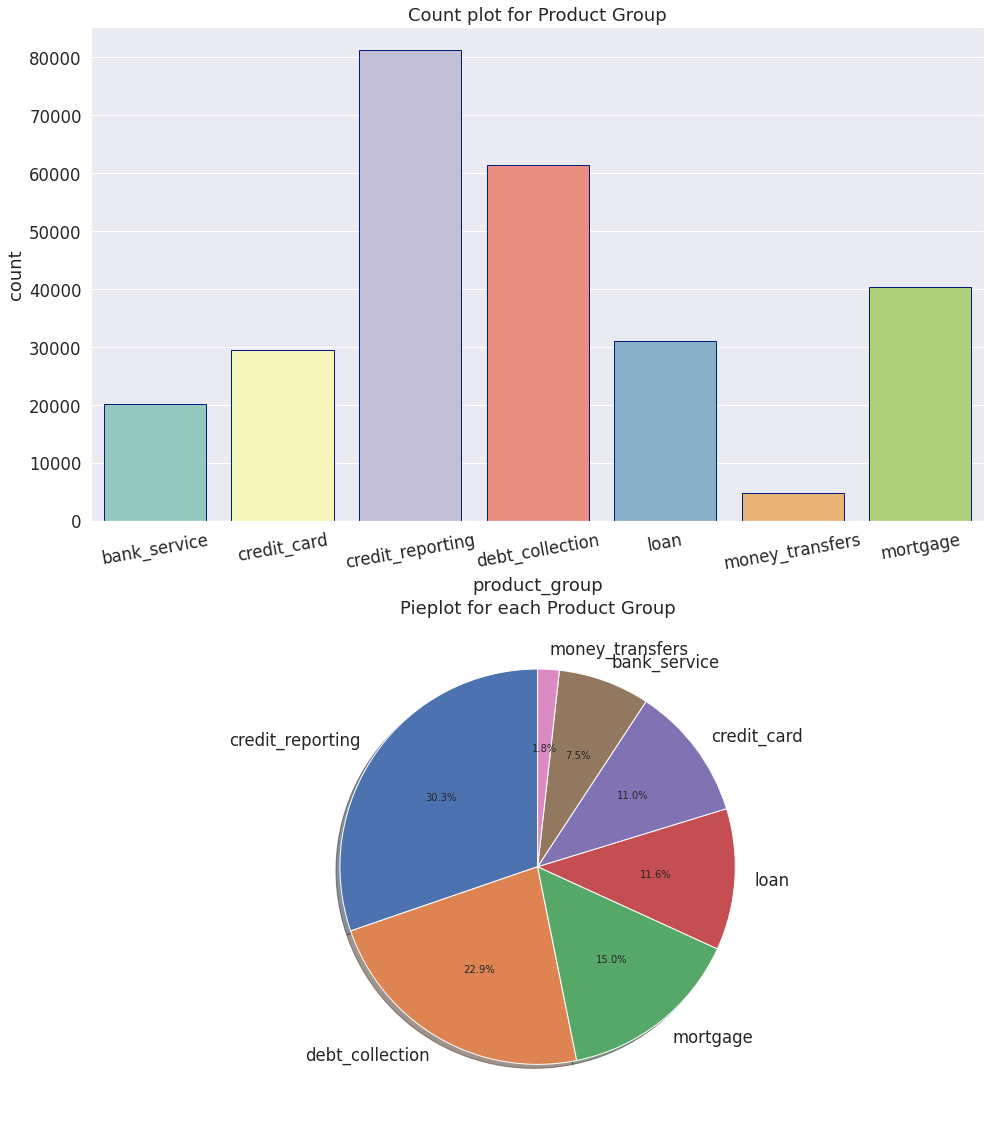

In [ ]:
plt.figure(figsize=(16,20))
plt.subplot(2,1,1)
sns.countplot(x = "product_group", data = casestudy_df,palette="Set3",edgecolor=sns.color_palette("dark", 1))
plt.title("Count plot for Product Group")
plt.xticks(rotation=10)

plt.subplot(2,1,2)
count = casestudy_df.product_group.value_counts()
labels = casestudy_df.product_group.value_counts().index
ax = plt.pie(count, labels=labels,shadow=True, autopct='%1.1f%%',startangle=90)
plt.title("Pieplot for each Product Group")
plt.show()

In [5]:
casestudy_df.product_group.value_counts()

credit_reporting    81230
debt_collection     61455
mortgage            40279
loan                31035
credit_card         29553
bank_service        20071
money_transfers      4734
Name: product_group, dtype: int64

## 1b. Analyzing Unstructured Textual Data: Text

The corpus in the text field contains many information. Gaining a priori syntactive and semantic information is possible suing python libraries like Spacy and NTLK. When analyzing the basis structure (number of alphabetical words) and type of characters contained in each text, I observe the following generalized types of words:

*   Alphabetical Words, alpha numeric, numeric only, punctuations, symbols etc are present.
*   Some masked information is present in the form of XXXX etc
*   Cases with Possibly white Spaces in the document
*   Some cases are in the form of email conversation.
*   No Emojis

In [6]:
for cnt,txt in enumerate(casestudy_df.text[0:10]):
  print(cnt,"---------->",txt)

0 ----------> On XX/XX/2017 my check # XXXX was debited from my checking account, and this check wasn't cashed by XXXX XXXX XXXX, I requested a copy of the endorsement of whom the fund was credited to, Bank of America can't give me satisfactory answer, since this contractor breach of contract that I needed proof of payment in court.
1 ----------> I opened a Bank of the the West account. The account came with a promotion. The promotion was get {$100.00} for setting up a qualifying direct deposit. I have received that promotion. The other promotion was, " get {$50.00} for making XXXX debit card purchases each month for 2 months. '' I have met the terms for the {$50.00} promotion and have not received the promotion that I am entitled to. I want the {$50.00} that I am entitled to that Bank of the West has not given me.
2 ----------> wells fargo in nj opened a business account without my authorization in early 2015 and also lied about fees not being charged on a wells fargo account i have h

### Number of Paragrphs
For starters, I analyze the basic structure information on the total collection of corpus available. I first look into the numbmer of paragraphs in each cases.

The criteria I use is that separation is of two new line or more (\n\n+) denotes the presence of paragraph change. With some exception to high paragraph numbers or (double spacing between text) most of the content is skewed toward lower paragraph count (1 or more).

When plotted with respect to product_group, I find little or no dependency with the product_group type


In [19]:
casestudy_df['number_of_paragraph'] = casestudy_df.text.apply(lambda x: 1+len(re.findall("\n\n+", x)))
casestudy_df.number_of_paragraph.describe()

count    268357.000000
mean          1.551243
std           1.967225
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         192.000000
Name: number_of_paragraph, dtype: float64

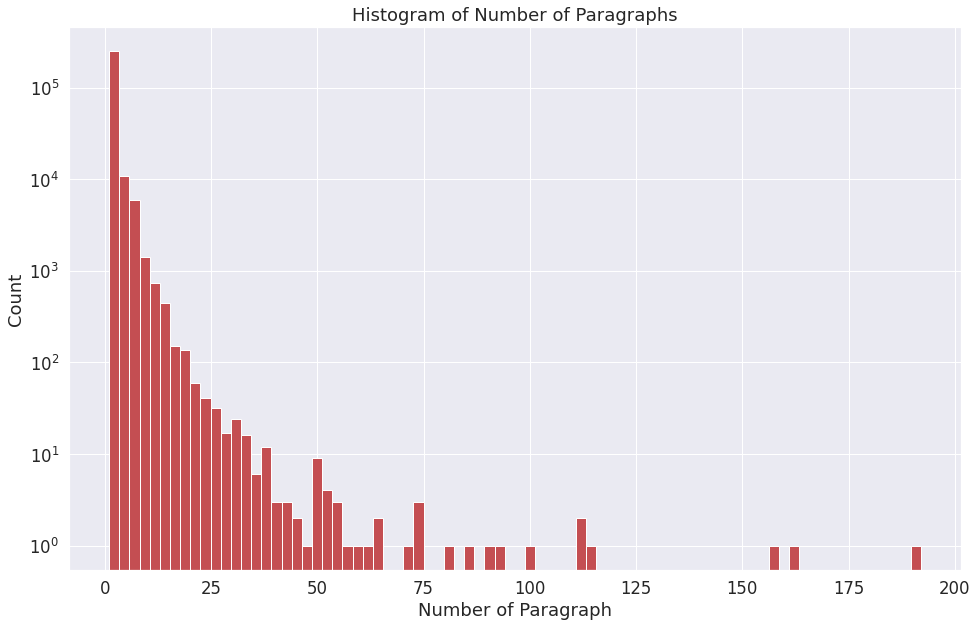

In [22]:
plt.figure(figsize=(16,10))
plt.hist(casestudy_df.number_of_paragraph,bins=80, color='R', log = True)
plt.xlabel("Number of Paragraph")
plt.ylabel("Count")
plt.title("Histogram of Number of Paragraphs")
plt.show()

Text(0.5, 1.0, 'Number of paragraph for each Product Group')

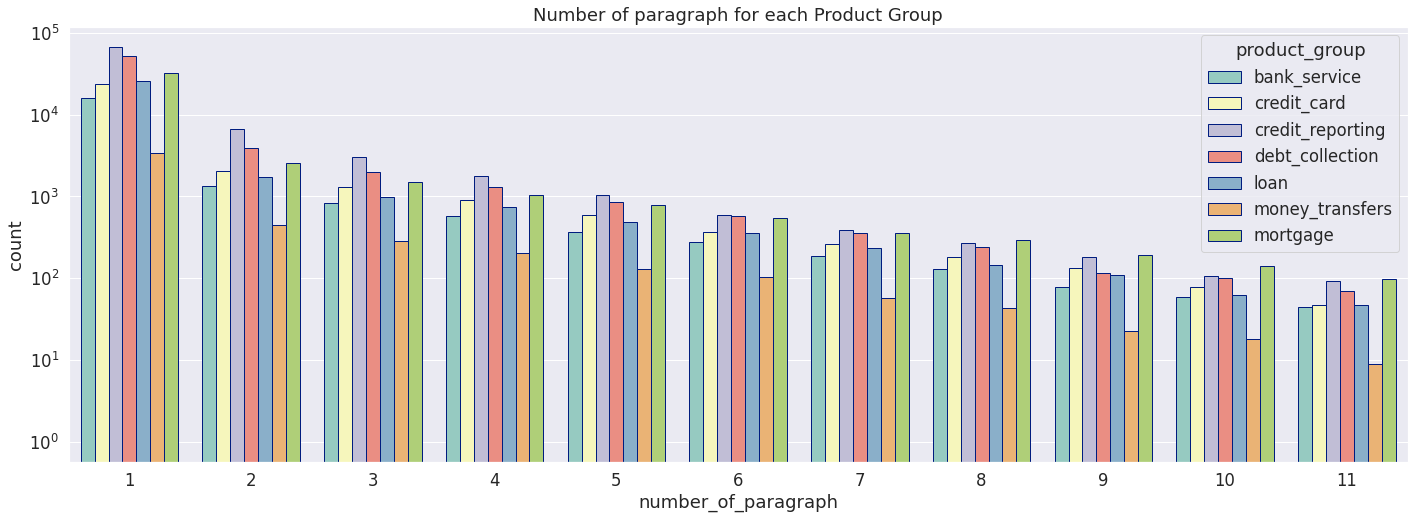

In [20]:
plt.figure(figsize=(24,8))
g = sns.countplot(data=casestudy_df, x="number_of_paragraph", hue="product_group",palette="Set3",edgecolor=sns.color_palette("dark", 1))
g.set_yscale('log')
plt.xlim(-0.5, 10.5)
plt.title("Number of paragraph for each Product Group")

### Word Count

I analysis roughly the **Total word count** in the raw textual document.

The average word count for our collection : **197**

The standard deviation on the word count distribution is : **207**

The extremely wordy complaint cases accounts for  **11.5%**

In [24]:
casestudy_df["number_of_words"] = casestudy_df.text.apply(lambda x: len(x.split()))
casestudy_df.number_of_words.describe()

count    268357.000000
mean        196.939305
std         207.244047
min           1.000000
25%          72.000000
50%         136.000000
75%         251.000000
max        6314.000000
Name: number_of_words, dtype: float64

In [23]:
# Outlier cases of word greater than avg+1*std
casestudy_df[casestudy_df.number_of_words >400].count()/casestudy_df.count()

complaint_id                0.115548
product_group               0.115548
text                        0.115548
number_of_words             0.115548
number_of_paragraph         0.115548
number_of_paragraph_add1    0.115548
dtype: float64

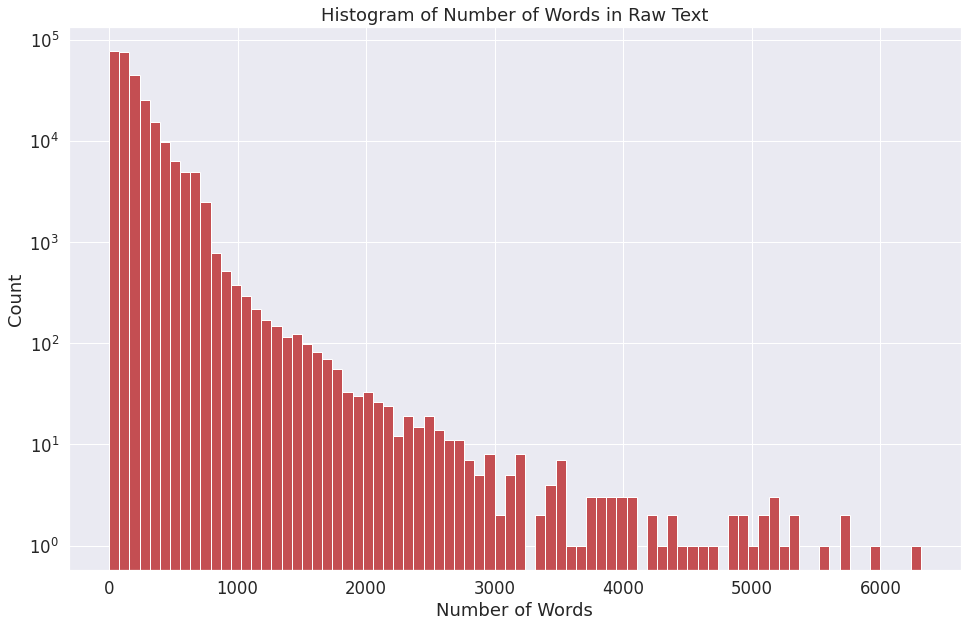

In [11]:
plt.figure(figsize=(16,10))
plt.hist(casestudy_df.number_of_words,bins=80, color='R', log = True)
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.title("Histogram of Number of Words in Raw Text")
plt.show()

When observing variation of word count among different product_group, I observe that:
1. Higher word counts for mortgage category
2. Lesser word counts for compalints belonging to credit_reporting and debt_collection.

This feature can be useful for our classification modeling problem.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


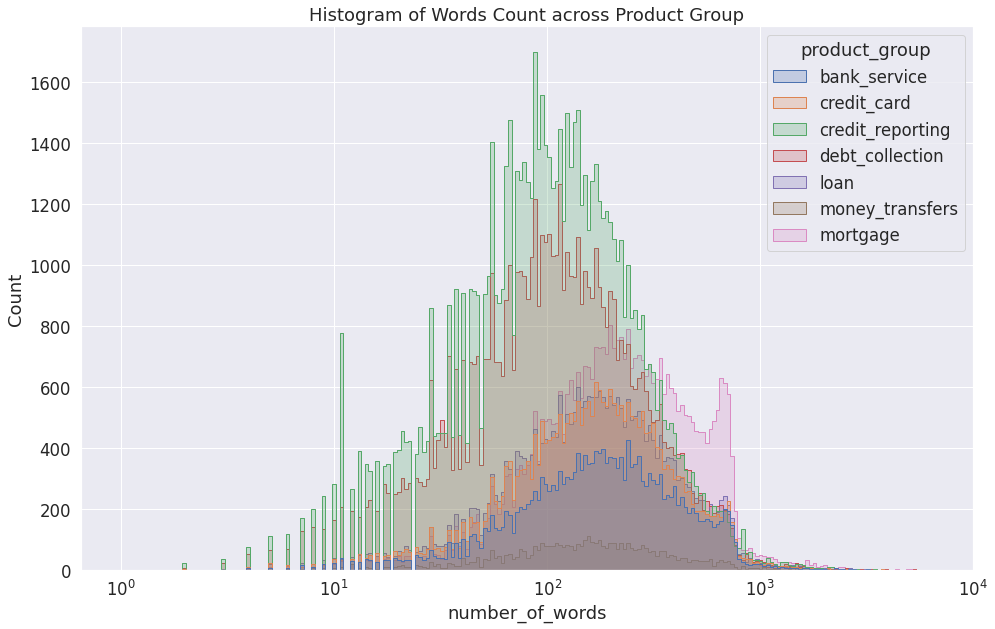

In [25]:
plt.figure(figsize=(16,10))
sns.histplot(data=casestudy_df, x="number_of_words", hue="product_group", element="step",log_scale=True)
plt.xlim(0,10000)
plt.title("Histogram of Words Count across Product Group")
plt.show()

Box plot (limited to word count of 400) shows the different in average word count among various product_group.

Also note that interquartile range for credit reporting and debt collection cases is lower than others

(0.0, 410.0)

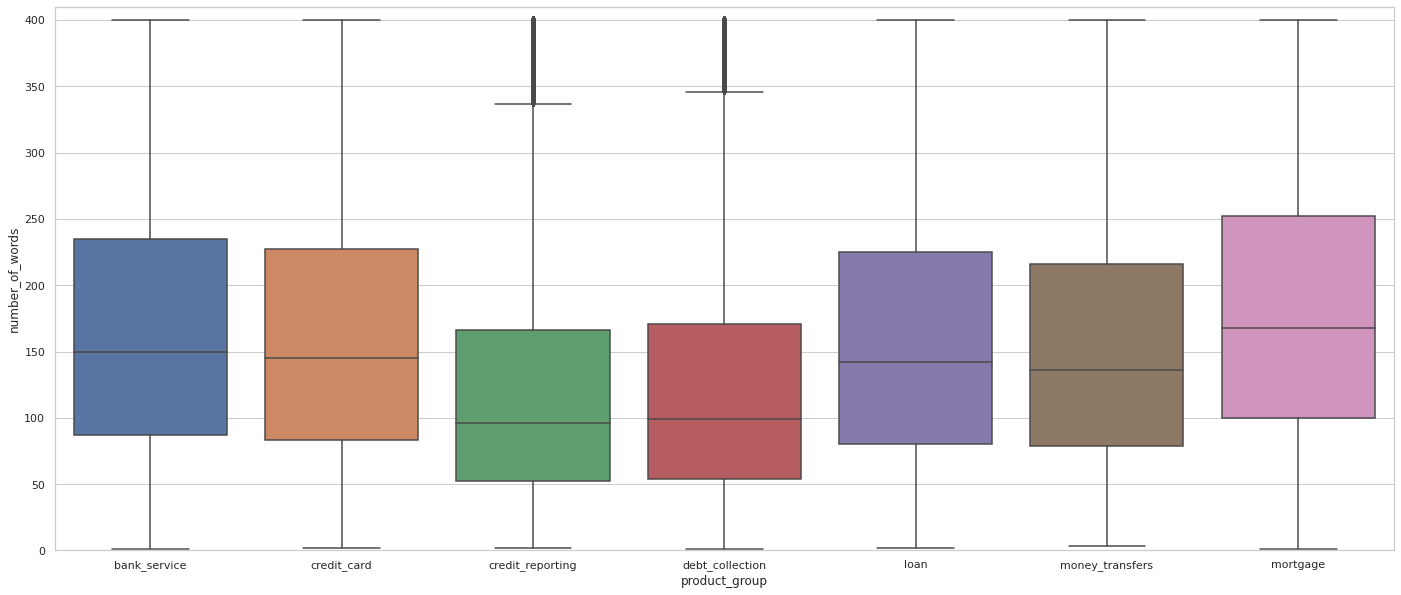

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(24,10))
sns.boxplot(y="number_of_words", x="product_group",data=casestudy_df[casestudy_df.number_of_words <=400])
plt.ylim(0,410)

I also look into the non alphabetic and numerical characters present in our collection (including punctuation). Overall, the distribution suggest an average of 28 such characters.

From visualization no obvious difference among product group is found for these characters

In [26]:
def text_non_alpha_digit(text):
    text = ' '.join(text.split())
    text = re.findall("[\W]",text)
    text = [ele for ele in text if ele != ' ']
    return text

In [29]:
for ind,ele in enumerate(casestudy_df.text):
  # Remove white spacing before converting to sentences 
  casestudy_df.loc[ind,'non_alpha_digit'] = len(text_non_alpha_digit(ele))
  if ind%10000 == 0:
    print(ind)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000


In [31]:
casestudy_df.non_alpha_digit.describe()

count    268357.000000
mean         28.032844
std          39.416208
min           0.000000
25%           8.000000
50%          17.000000
75%          35.000000
max        5229.000000
Name: non_alpha_digit, dtype: float64

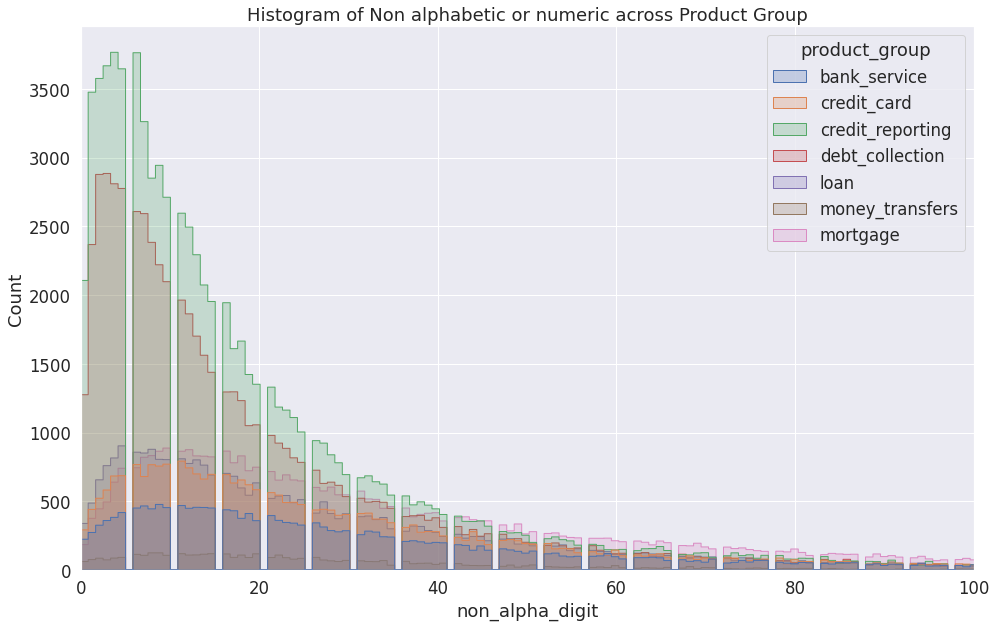

In [44]:

plt.figure(figsize=(16,10))
sns.histplot(data=casestudy_df, x="non_alpha_digit", hue="product_group", element="step",log_scale=False)
plt.xlim(0,100)
plt.title("Histogram of Non alphabetic or numeric across Product Group")
plt.show()

In [42]:
casestudy_df.to_csv('10122020_processed_save_v1.csv')
!cp 10122020_processed_save_v1.csv "/content/gdrive/My Drive/Colab Notebooks/Wells Fargo Assignment/"
#file = "/content/gdrive/My Drive/Colab Notebooks/Wells Fargo Assignment/10122020_processed_save_v1.csv"
#casestudy_df2 = pd.read_csv(file)

In [45]:
casestudy_df
#casestudy_df2.columns[0]

,complaint_id,product_group,text,number_of_words,number_of_paragraph,number_of_paragraph_add1,non_alpha_digit
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...,57,1,1,10.0
1,2217937,bank_service,I opened a Bank of the the West account. The a...,89,1,1,27.0
2,2657456,bank_service,wells fargo in nj opened a business account wi...,50,1,1,1.0
3,1414106,bank_service,A hold was placed on my saving account ( XXXX ...,245,1,1,38.0
4,1999158,bank_service,Dear CFPB : I need to send a major concern/com...,648,7,7,221.0
...,...,...,...,...,...,...,...
268352,1880092,mortgage,I have recently been declined for a loan due t...,218,1,1,30.0
268353,2643322,mortgage,I am XXXX XXXX military. I requested help from...,99,1,1,6.0
268354,2351168,mortgage,The collections department at Wells Fargo bega...,140,1,1,22.0
268355,1553913,mortgage,I was denied the chance to continue an applica...,121,1,1,15.0


# 2. Data Preparation

## 2a. Resampling the collection based on Product Group

We noticed that the current dataset is undersampled for the **money_transfers** product_group where as **credit_reporting** and **debit_collection** has high count.


To create a generalized and balanced classification model, I randomly sample roughly 5000 complaint cases from each category. Better methods in sklearn are present : Tomek Links and Cluster Centroid, but need additional tuning in parameters

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

From visualize, I observe that the distribution are overall balanced

In [46]:
casestudy_df.product_group.unique()

array(['bank_service', 'credit_card', 'credit_reporting',
       'debt_collection', 'loan', 'money_transfers', 'mortgage'],
      dtype=object)

In [54]:
arr = casestudy_df.product_group.unique()
rand = 1
casestudy_df_resamp = casestudy_df[casestudy_df.product_group==arr[0]].sample(n=5000, random_state = rand )
for ele in arr[1:]:
  lent = sum(casestudy_df.product_group==ele)
  if (lent > 5000):
    lent = 5000
  casestudy_df_resamp = pd.concat([casestudy_df_resamp,casestudy_df[casestudy_df.product_group==ele].sample(n=lent, random_state=rand)])

In [55]:
casestudy_df_resamp = casestudy_df_resamp.reset_index()
casestudy_df_resamp.drop(['index'],axis=1,inplace=True)
casestudy_df_resamp

,complaint_id,product_group,text,number_of_words,number_of_paragraph,number_of_paragraph_add1,non_alpha_digit
0,2312907,bank_service,We opened a checking account for my daughter a...,173,1,1,20.0
1,2578891,bank_service,I have been charged XXXX overdraft fees due ...,54,1,1,4.0
2,2916315,bank_service,This is a Very sick company!!! i have called t...,295,2,2,108.0
3,2789763,bank_service,"Opened new checking account on XX/XX/XXXX, at ...",54,1,1,17.0
4,2173648,bank_service,Popular Community Bank 's mobile application l...,200,1,1,18.0
...,...,...,...,...,...,...,...
34729,1816409,mortgage,Our mortgage servicer failed to pay our XXXX p...,397,1,1,51.0
34730,2210605,mortgage,"XXXX XXXX, XXXX Attention : CFPD, Wells Fargo ...",645,3,3,108.0
34731,1735415,mortgage,"Seterus, Inc. has failed to remit my {$1500.00...",129,1,1,18.0
34732,2882555,mortgage,We executed a modification in XX/XX/XXXX with ...,654,1,1,185.0


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

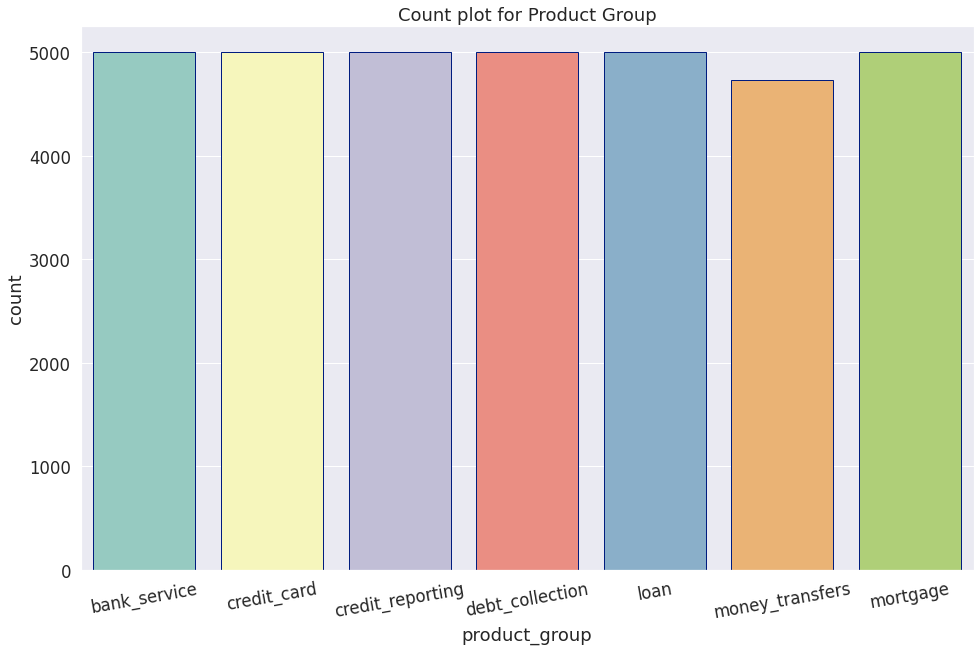

In [56]:
plt.figure(figsize=(16,10))
sns.countplot(x = "product_group", data = casestudy_df_resamp,palette="Set3",edgecolor=sns.color_palette("dark", 1))
plt.title("Count plot for Product Group")
plt.xticks(rotation=10)

## 2b. Textual Processing

I now process the raw textual data to a simpler form. I use the regex for.
1. Remove the additional white spacing (leading and trailing)
2. Remove the masked words XXX 
3. Remove non alphabetic and numerical characters
4. Remove Punctuations and Apostrophe
5. Normalize all words to lowercase


In a separate step, I use spaCY and NLTK to
1. Remove stop words and simplifying relevent words
2. Lemmentization to reduce wording complexity
3. Record the POS tagging (Grammatic Information)

Note: there are proper noun present in the content that can be removed as these are not needed in our method

In [59]:
def text_cleaner(text):
    # visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  better get rid of it now!
    text = ' '.join(text.split())
    text = re.sub(r'\bXX\S+', "", text)
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+|\d*\w)\b", " ", text)
    text = re.sub("[']",'',text)
    text = re.sub("[\W]",' ',text)
    text = ' '.join(text.split())
    return text.lower()

In [60]:
for ind,ele in enumerate(casestudy_df_resamp.text):
  # Remove white spacing before converting to sentences 
  casestudy_df_resamp.loc[ind,'text_processed'] = text_cleaner(ele)
  if ind%5000 == 0:
    print(ind)

0
5000
10000
15000
20000
25000
30000


In [62]:
casestudy_df_resamp

,complaint_id,product_group,text,number_of_words,number_of_paragraph,number_of_paragraph_add1,non_alpha_digit,text_processed
0,2312907,bank_service,We opened a checking account for my daughter a...,173,1,1,20.0,we opened checking account for my daughter at ...
1,2578891,bank_service,I have been charged XXXX overdraft fees due ...,54,1,1,4.0,have been charged overdraft fees due to accoun...
2,2916315,bank_service,This is a Very sick company!!! i have called t...,295,2,2,108.0,this is very sick company have called them and...
3,2789763,bank_service,"Opened new checking account on XX/XX/XXXX, at ...",54,1,1,17.0,opened new checking account on at which time i...
4,2173648,bank_service,Popular Community Bank 's mobile application l...,200,1,1,18.0,popular community bank mobile application list...
...,...,...,...,...,...,...,...,...
34729,1816409,mortgage,Our mortgage servicer failed to pay our XXXX p...,397,1,1,51.0,our mortgage servicer failed to pay our proper...
34730,2210605,mortgage,"XXXX XXXX, XXXX Attention : CFPD, Wells Fargo ...",645,3,3,108.0,attention cfpd wells fargo did not allow hamp ...
34731,1735415,mortgage,"Seterus, Inc. has failed to remit my {$1500.00...",129,1,1,18.0,seterus inc has failed to remit my escrow reim...
34732,2882555,mortgage,We executed a modification in XX/XX/XXXX with ...,654,1,1,185.0,we executed modification in with and signed an...


In [61]:
casestudy_df_resamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34734 entries, 0 to 34733
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   complaint_id              34734 non-null  int64  
 1   product_group             34734 non-null  object 
 2   text                      34734 non-null  object 
 3   number_of_words           34734 non-null  int64  
 4   number_of_paragraph       34734 non-null  int64  
 5   number_of_paragraph_add1  34734 non-null  int64  
 6   non_alpha_digit           34734 non-null  float64
 7   text_processed            34734 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 2.1+ MB


In [69]:
for cnt,ele in enumerate(casestudy_df_resamp.text_processed):
  complaint_doc = nlp(ele)
  casestudy_df_resamp.loc[cnt,'text_processed_no_stopword'] = ' '.join([token.lemma_ for token in complaint_doc if not token.is_stop if token.is_alpha])
  casestudy_df_resamp.loc[cnt,'text_processed_no_stopword_pos'] = ' '.join([token.pos_ for token in complaint_doc if not token.is_stop if token.is_alpha])
  if cnt%5000 == 0:
    print(cnt)

0
5000
10000
15000
20000
25000
30000


In [72]:
casestudy_df_resamp

,complaint_id,product_group,text,number_of_words,number_of_paragraph,number_of_paragraph_add1,non_alpha_digit,text_processed,text_processed_no_stopword,text_processed_no_stopword_pos
0,2312907,bank_service,We opened a checking account for my daughter a...,173,1,1,20.0,we opened checking account for my daughter at ...,open check account daughter bank prior go coll...,VERB VERB NOUN NOUN NOUN ADV VERB NOUN VERB AD...
1,2578891,bank_service,I have been charged XXXX overdraft fees due ...,54,1,1,4.0,have been charged overdraft fees due to accoun...,charge overdraft fee account error balance ser...,VERB NOUN NOUN NOUN NOUN NOUN NOUN PROPN NOUN ...
2,2916315,bank_service,This is a Very sick company!!! i have called t...,295,2,2,108.0,this is very sick company have called them and...,sick company call return fund family transfer ...,ADJ NOUN VERB VERB NOUN NOUN VERB NOUN NOUN NO...
3,2789763,bank_service,"Opened new checking account on XX/XX/XXXX, at ...",54,1,1,17.0,opened new checking account on at which time i...,open new check account time institution offer ...,VERB ADJ VERB NOUN NOUN NOUN VERB NOUN ADJ NOU...
4,2173648,bank_service,Popular Community Bank 's mobile application l...,200,1,1,18.0,popular community bank mobile application list...,popular community bank mobile application list...,PROPN PROPN PROPN PROPN NOUN NOUN ADV VERB ADJ...
...,...,...,...,...,...,...,...,...,...,...
34729,1816409,mortgage,Our mortgage servicer failed to pay our XXXX p...,397,1,1,51.0,our mortgage servicer failed to pay our proper...,mortgage servicer fail pay property taxis time...,NOUN NOUN VERB VERB NOUN NOUN NOUN VERB NOUN A...
34730,2210605,mortgage,"XXXX XXXX, XXXX Attention : CFPD, Wells Fargo ...",645,3,3,108.0,attention cfpd wells fargo did not allow hamp ...,attention cfpd wells fargo allow hamp modifica...,NOUN PROPN PROPN PROPN VERB NOUN NOUN PROPN PR...
34731,1735415,mortgage,"Seterus, Inc. has failed to remit my {$1500.00...",129,1,1,18.0,seterus inc has failed to remit my escrow reim...,seterus inc fail remit escrow reimbursement da...,PROPN PROPN VERB VERB NOUN NOUN NOUN NOUN NOUN...
34732,2882555,mortgage,We executed a modification in XX/XX/XXXX with ...,654,1,1,185.0,we executed modification in with and signed an...,execute modification sign notarized modificati...,VERB NOUN VERB ADJ NOUN NOUN VERB ADV VERB VER...


In [3]:
#casestudy_df_resamp.to_csv('10122020_processed_save_v1_resamp.csv')
#!cp 10122020_processed_save_v1_resamp.csv "/content/gdrive/My Drive/Colab Notebooks/Wells Fargo Assignment/"

file_load = "/content/gdrive/My Drive/Colab Notebooks/Wells Fargo Assignment/10122020_processed_save_v1_resamp.csv"
casestudy_df_resamp = pd.read_csv(file_load)
casestudy_df_resamp

,Unnamed: 0,complaint_id,product_group,text,number_of_words,number_of_paragraph,number_of_paragraph_add1,non_alpha_digit,text_processed,text_processed_no_stopword,text_processed_no_stopword_pos
0,0,2312907,bank_service,We opened a checking account for my daughter a...,173,1,1,20.0,we opened checking account for my daughter at ...,open check account daughter bank prior go coll...,VERB VERB NOUN NOUN NOUN ADV VERB NOUN VERB AD...
1,1,2578891,bank_service,I have been charged XXXX overdraft fees due ...,54,1,1,4.0,have been charged overdraft fees due to accoun...,charge overdraft fee account error balance ser...,VERB NOUN NOUN NOUN NOUN NOUN NOUN PROPN NOUN ...
2,2,2916315,bank_service,This is a Very sick company!!! i have called t...,295,2,2,108.0,this is very sick company have called them and...,sick company call return fund family transfer ...,ADJ NOUN VERB VERB NOUN NOUN VERB NOUN NOUN NO...
3,3,2789763,bank_service,"Opened new checking account on XX/XX/XXXX, at ...",54,1,1,17.0,opened new checking account on at which time i...,open new check account time institution offer ...,VERB ADJ VERB NOUN NOUN NOUN VERB NOUN ADJ NOU...
4,4,2173648,bank_service,Popular Community Bank 's mobile application l...,200,1,1,18.0,popular community bank mobile application list...,popular community bank mobile application list...,PROPN PROPN PROPN PROPN NOUN NOUN ADV VERB ADJ...
...,...,...,...,...,...,...,...,...,...,...,...
34729,34729,1816409,mortgage,Our mortgage servicer failed to pay our XXXX p...,397,1,1,51.0,our mortgage servicer failed to pay our proper...,mortgage servicer fail pay property taxis time...,NOUN NOUN VERB VERB NOUN NOUN NOUN VERB NOUN A...
34730,34730,2210605,mortgage,"XXXX XXXX, XXXX Attention : CFPD, Wells Fargo ...",645,3,3,108.0,attention cfpd wells fargo did not allow hamp ...,attention cfpd wells fargo allow hamp modifica...,NOUN PROPN PROPN PROPN VERB NOUN NOUN PROPN PR...
34731,34731,1735415,mortgage,"Seterus, Inc. has failed to remit my {$1500.00...",129,1,1,18.0,seterus inc has failed to remit my escrow reim...,seterus inc fail remit escrow reimbursement da...,PROPN PROPN VERB VERB NOUN NOUN NOUN NOUN NOUN...
34732,34732,2882555,mortgage,We executed a modification in XX/XX/XXXX with ...,654,1,1,185.0,we executed modification in with and signed an...,execute modification sign notarized modificati...,VERB NOUN VERB ADJ NOUN NOUN VERB ADV VERB VER...


In [4]:
casestudy_df_resamp.dropna(axis=0,inplace= True)
casestudy_df_resamp = casestudy_df_resamp.reset_index()
casestudy_df_resamp.drop(['index'],axis=1,inplace=True)
casestudy_df_resamp

,Unnamed: 0,complaint_id,product_group,text,number_of_words,number_of_paragraph,number_of_paragraph_add1,non_alpha_digit,text_processed,text_processed_no_stopword,text_processed_no_stopword_pos
0,0,2312907,bank_service,We opened a checking account for my daughter a...,173,1,1,20.0,we opened checking account for my daughter at ...,open check account daughter bank prior go coll...,VERB VERB NOUN NOUN NOUN ADV VERB NOUN VERB AD...
1,1,2578891,bank_service,I have been charged XXXX overdraft fees due ...,54,1,1,4.0,have been charged overdraft fees due to accoun...,charge overdraft fee account error balance ser...,VERB NOUN NOUN NOUN NOUN NOUN NOUN PROPN NOUN ...
2,2,2916315,bank_service,This is a Very sick company!!! i have called t...,295,2,2,108.0,this is very sick company have called them and...,sick company call return fund family transfer ...,ADJ NOUN VERB VERB NOUN NOUN VERB NOUN NOUN NO...
3,3,2789763,bank_service,"Opened new checking account on XX/XX/XXXX, at ...",54,1,1,17.0,opened new checking account on at which time i...,open new check account time institution offer ...,VERB ADJ VERB NOUN NOUN NOUN VERB NOUN ADJ NOU...
4,4,2173648,bank_service,Popular Community Bank 's mobile application l...,200,1,1,18.0,popular community bank mobile application list...,popular community bank mobile application list...,PROPN PROPN PROPN PROPN NOUN NOUN ADV VERB ADJ...
...,...,...,...,...,...,...,...,...,...,...,...
34728,34729,1816409,mortgage,Our mortgage servicer failed to pay our XXXX p...,397,1,1,51.0,our mortgage servicer failed to pay our proper...,mortgage servicer fail pay property taxis time...,NOUN NOUN VERB VERB NOUN NOUN NOUN VERB NOUN A...
34729,34730,2210605,mortgage,"XXXX XXXX, XXXX Attention : CFPD, Wells Fargo ...",645,3,3,108.0,attention cfpd wells fargo did not allow hamp ...,attention cfpd wells fargo allow hamp modifica...,NOUN PROPN PROPN PROPN VERB NOUN NOUN PROPN PR...
34730,34731,1735415,mortgage,"Seterus, Inc. has failed to remit my {$1500.00...",129,1,1,18.0,seterus inc has failed to remit my escrow reim...,seterus inc fail remit escrow reimbursement da...,PROPN PROPN VERB VERB NOUN NOUN NOUN NOUN NOUN...
34731,34732,2882555,mortgage,We executed a modification in XX/XX/XXXX with ...,654,1,1,185.0,we executed modification in with and signed an...,execute modification sign notarized modificati...,VERB NOUN VERB ADJ NOUN NOUN VERB ADV VERB VER...


## 2c. POS tags Statistics

Looking at the basic statistics of POS tags:
1. Count of Nouns is the largest followed by verb and adjectives
2. A lot of proper nouns are present that may need to be examined

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_pos = CountVectorizer(analyzer='word')
X_pos = vectorizer_pos.fit_transform(casestudy_df_resamp.text_processed_no_stopword_pos)
pos_df = pd.DataFrame(X_pos.toarray(), columns=vectorizer_pos.get_feature_names())
pos_df

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,sconj,sym,verb
0,5,0,1,0,0,0,35,0,0,0,0,0,0,0,20
1,2,0,1,0,0,0,15,0,0,0,3,0,0,0,6
2,14,0,4,0,0,0,60,0,0,0,5,0,0,0,34
3,3,0,0,0,0,0,14,0,0,0,0,0,0,0,9
4,6,2,5,0,0,0,42,0,0,0,12,0,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34728,17,0,7,0,0,0,83,0,0,0,2,0,0,0,60
34729,41,0,5,0,0,1,179,0,0,0,16,0,0,0,79
34730,2,0,1,0,0,0,27,0,0,0,6,0,0,0,14
34731,16,1,5,1,0,0,144,0,0,0,3,0,1,0,71


In [37]:
# Basic Statistics
pos_df.sum()

adj       253671
adp         2945
adv        94016
cconj       1300
det          541
intj        3390
noun     1387678
num         1034
part        3894
pron         917
propn     143273
punct         66
sconj       5352
sym            6
verb      906267
dtype: int64

<Figure size 864x576 with 0 Axes>

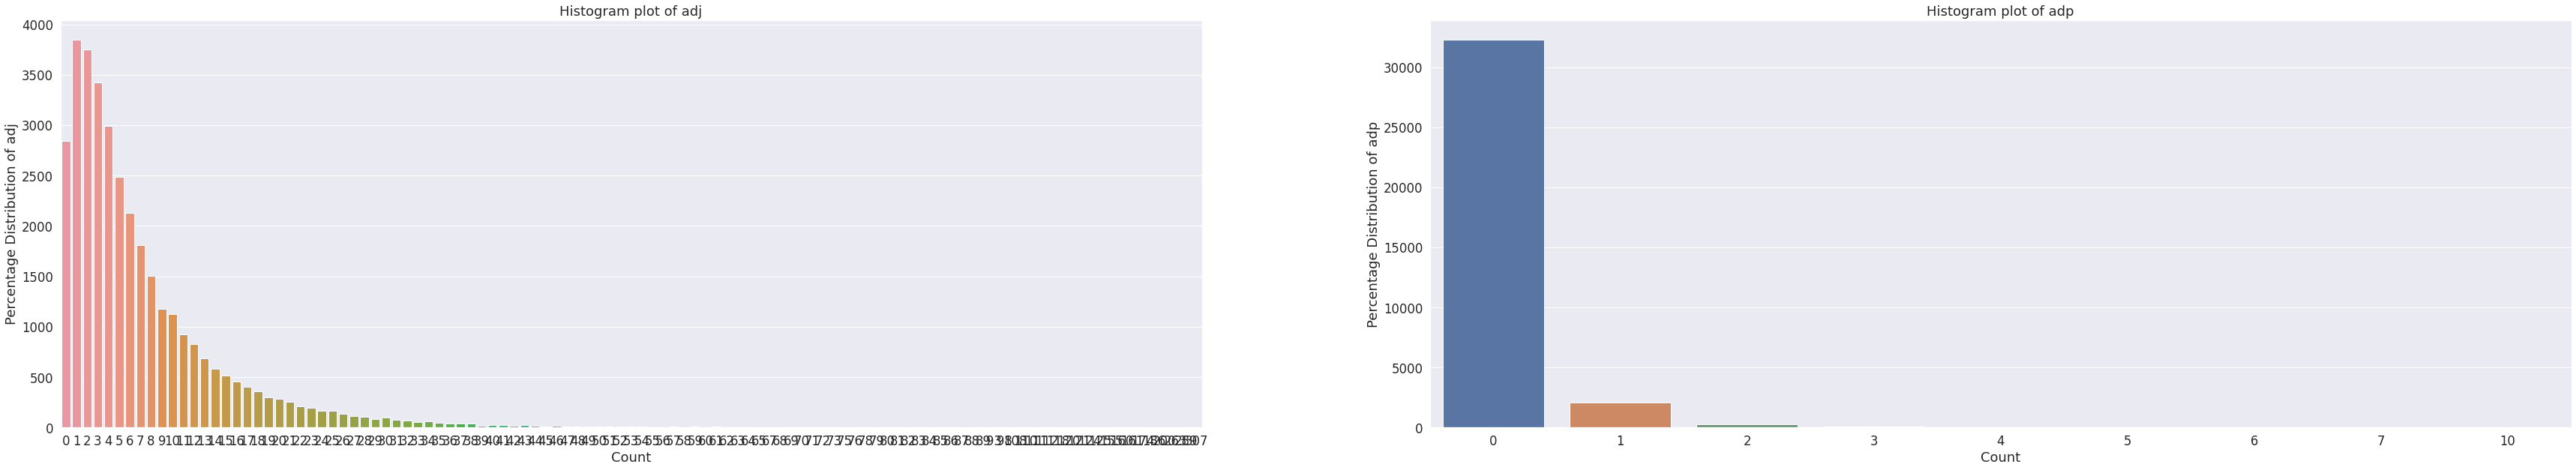

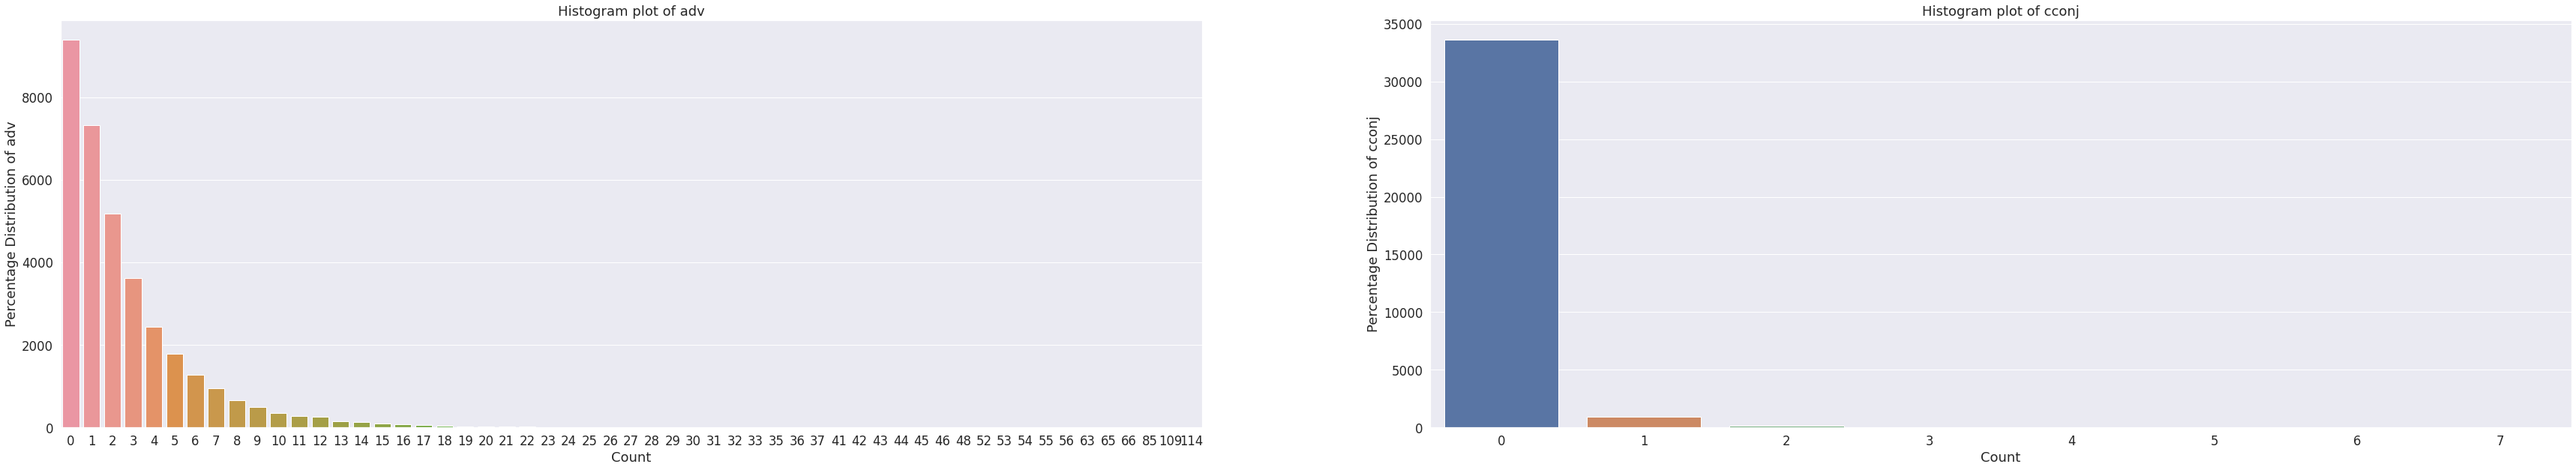

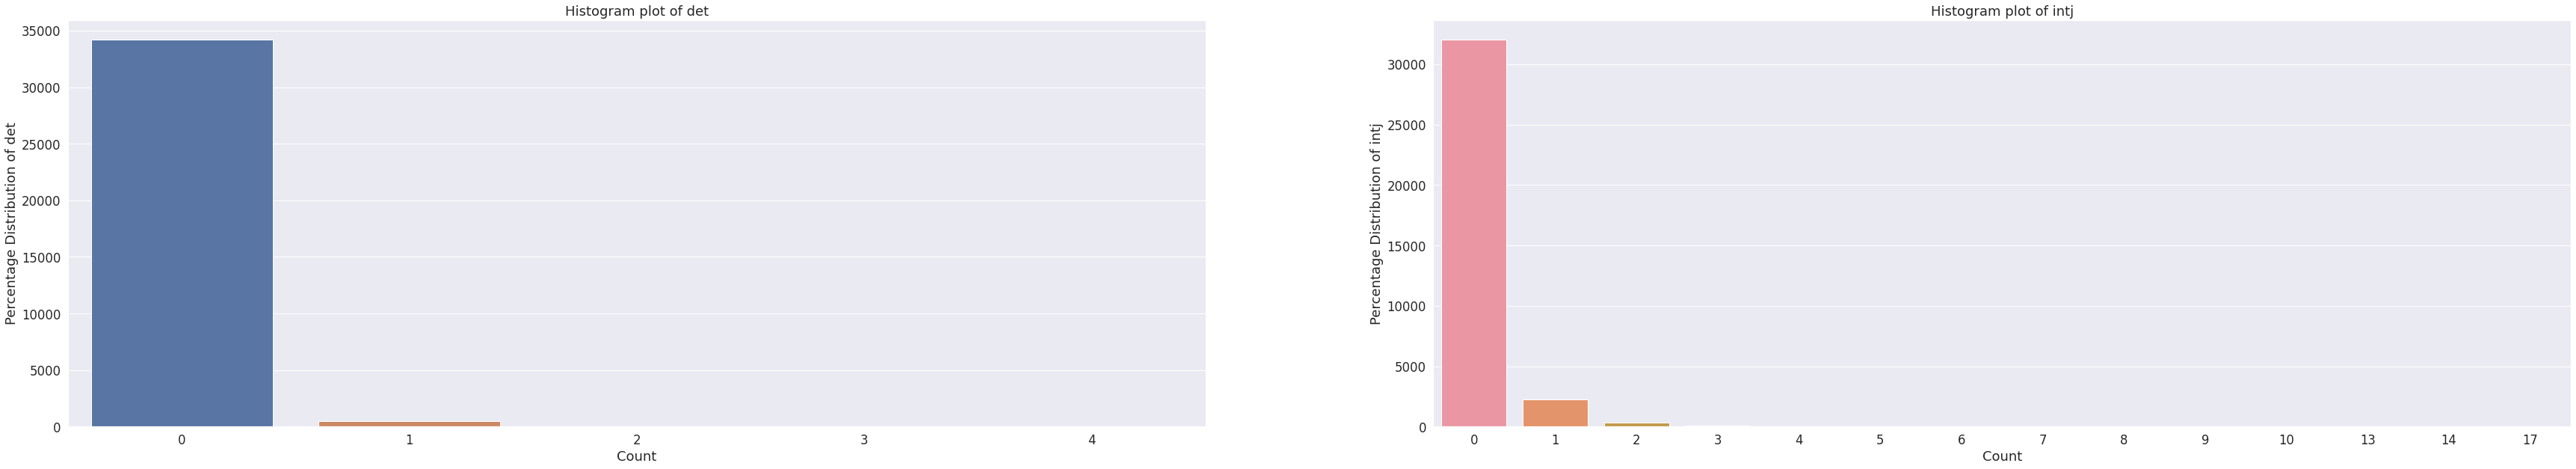

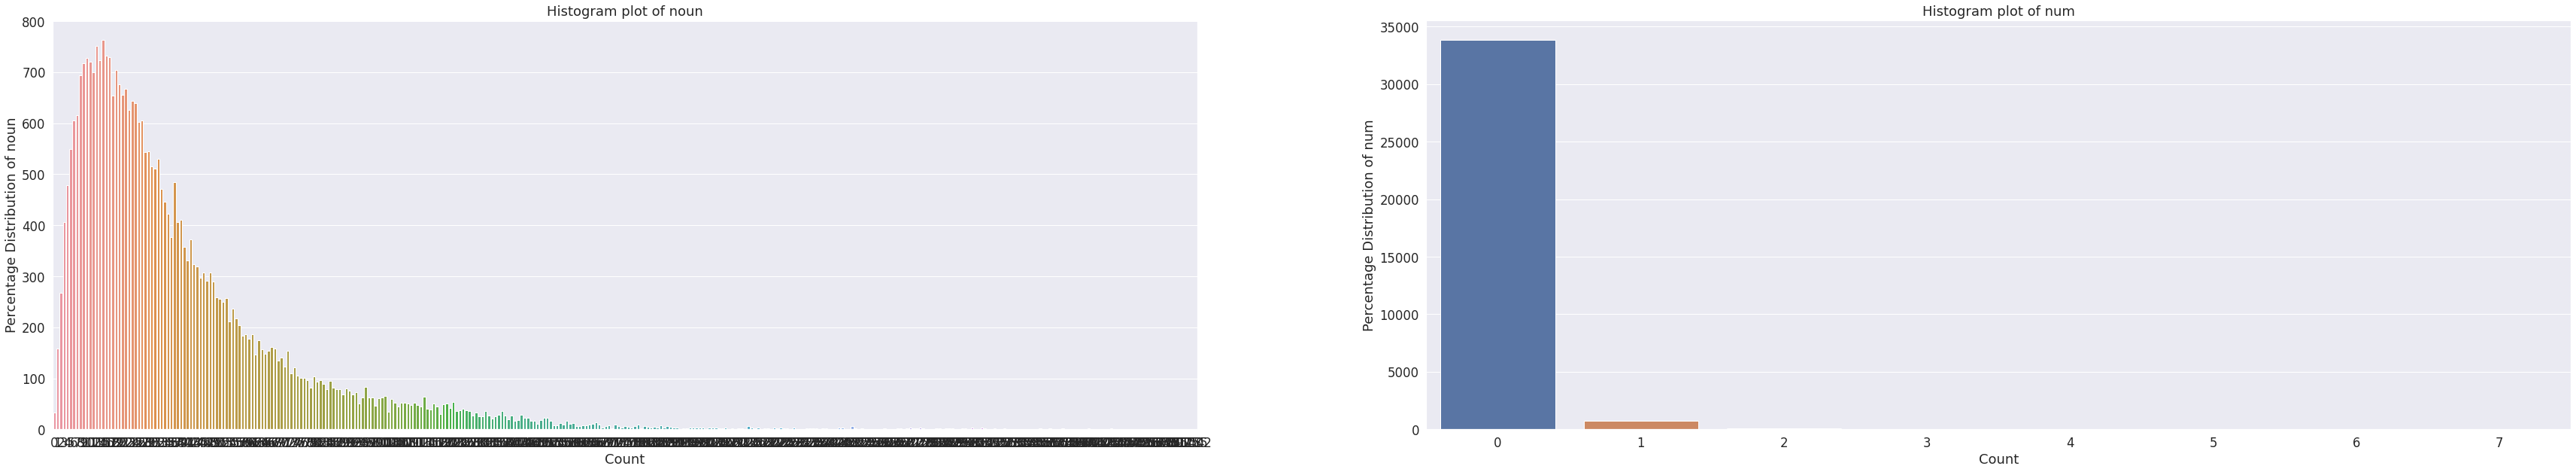

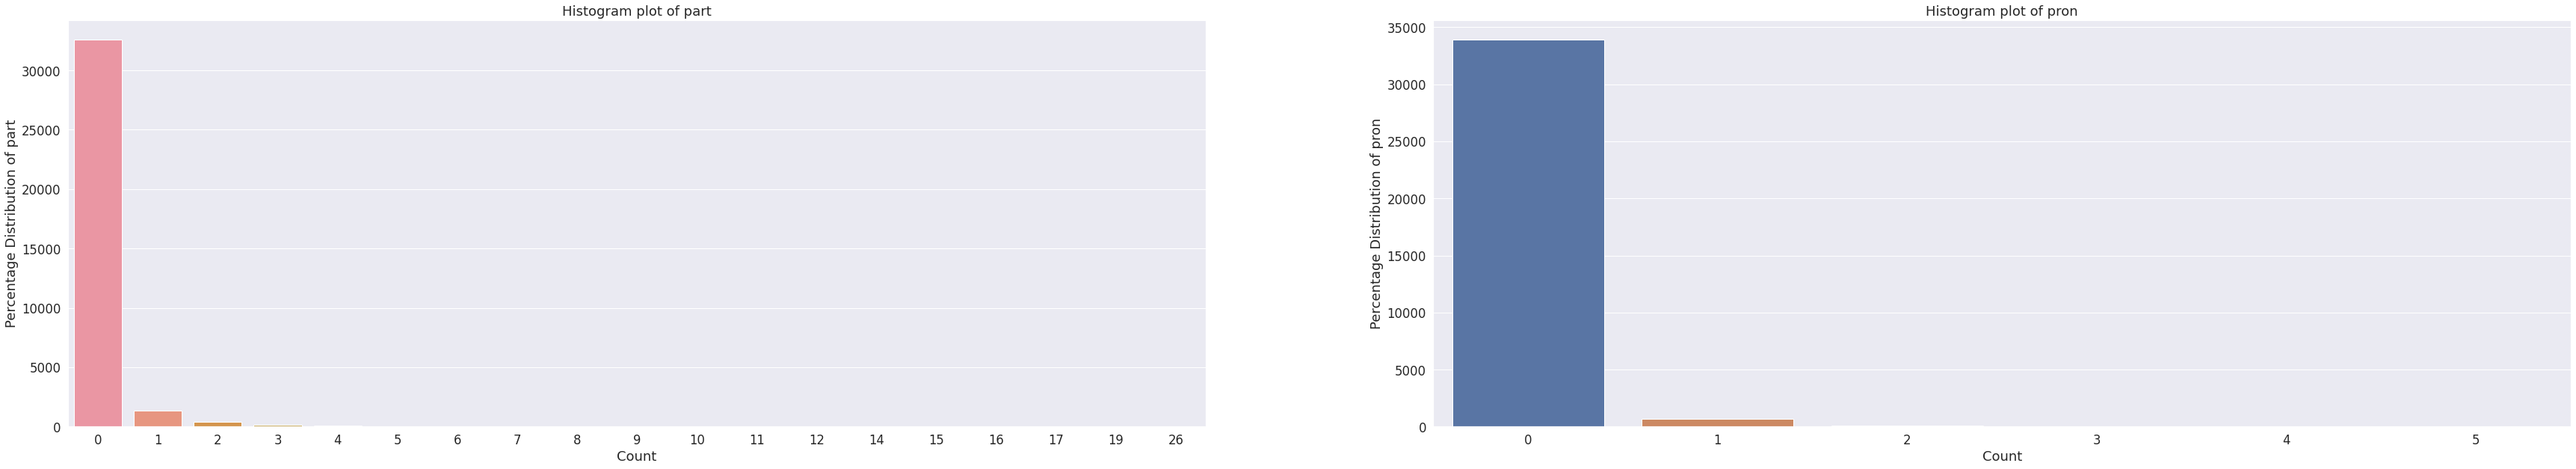

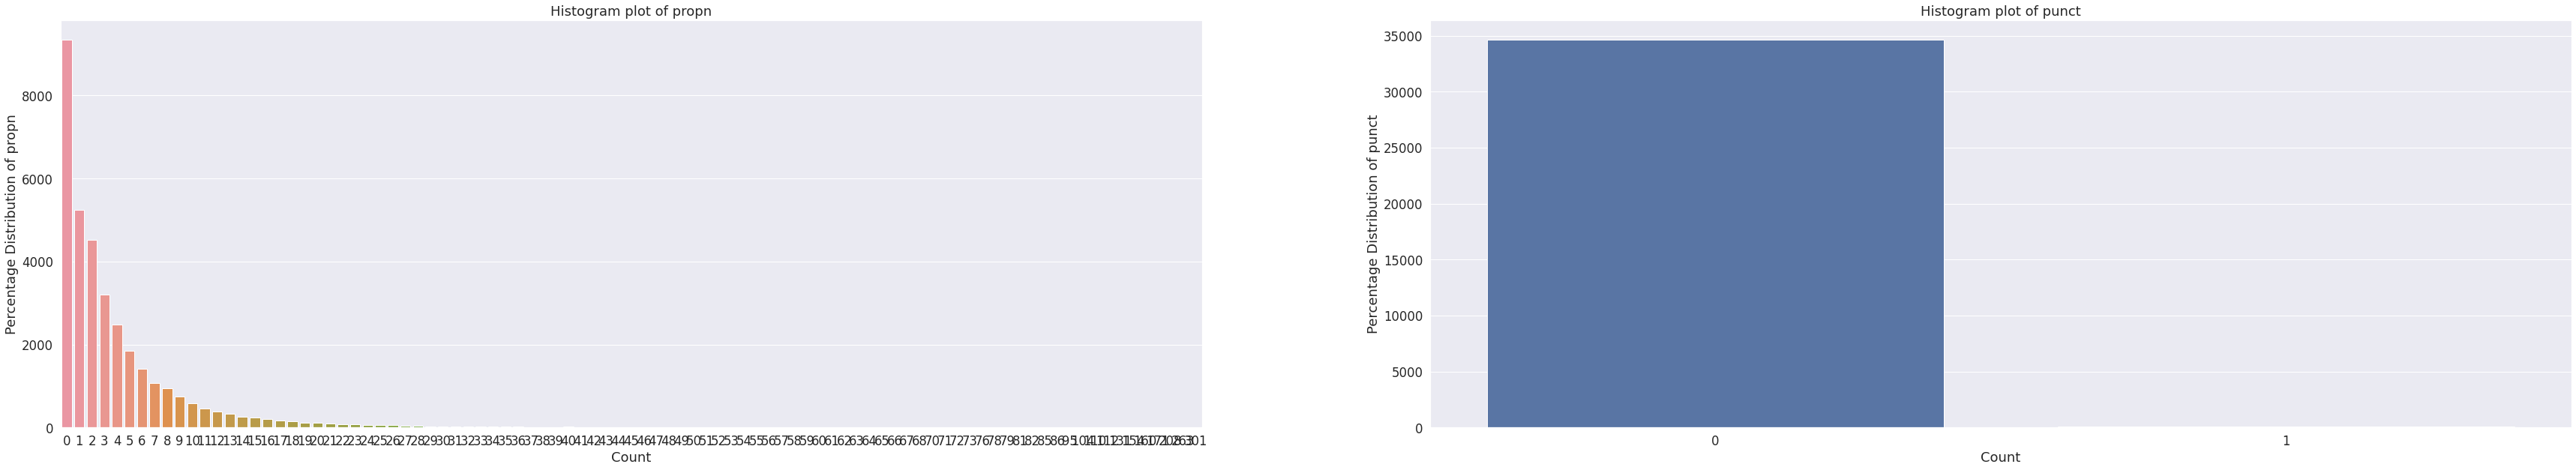

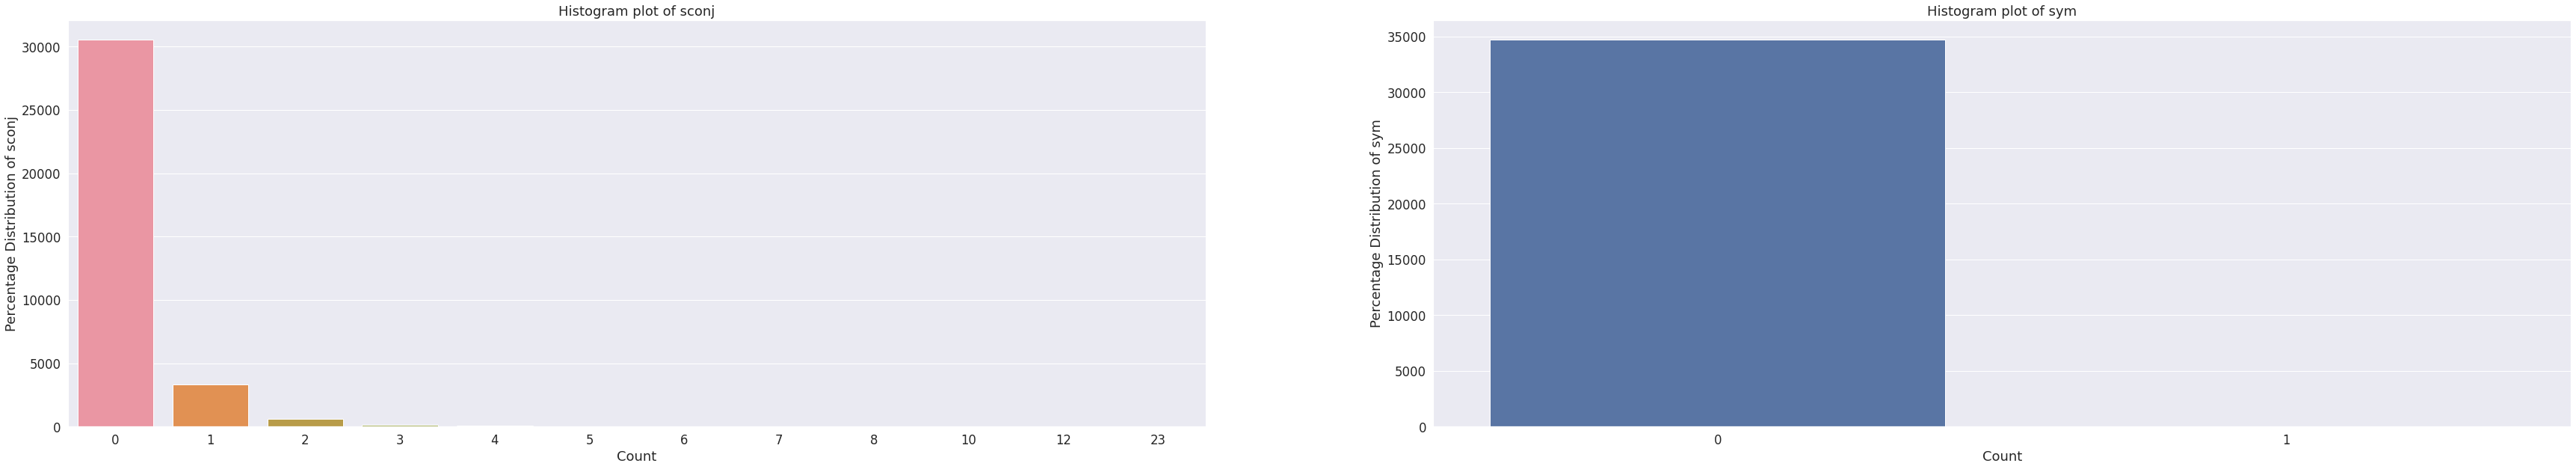

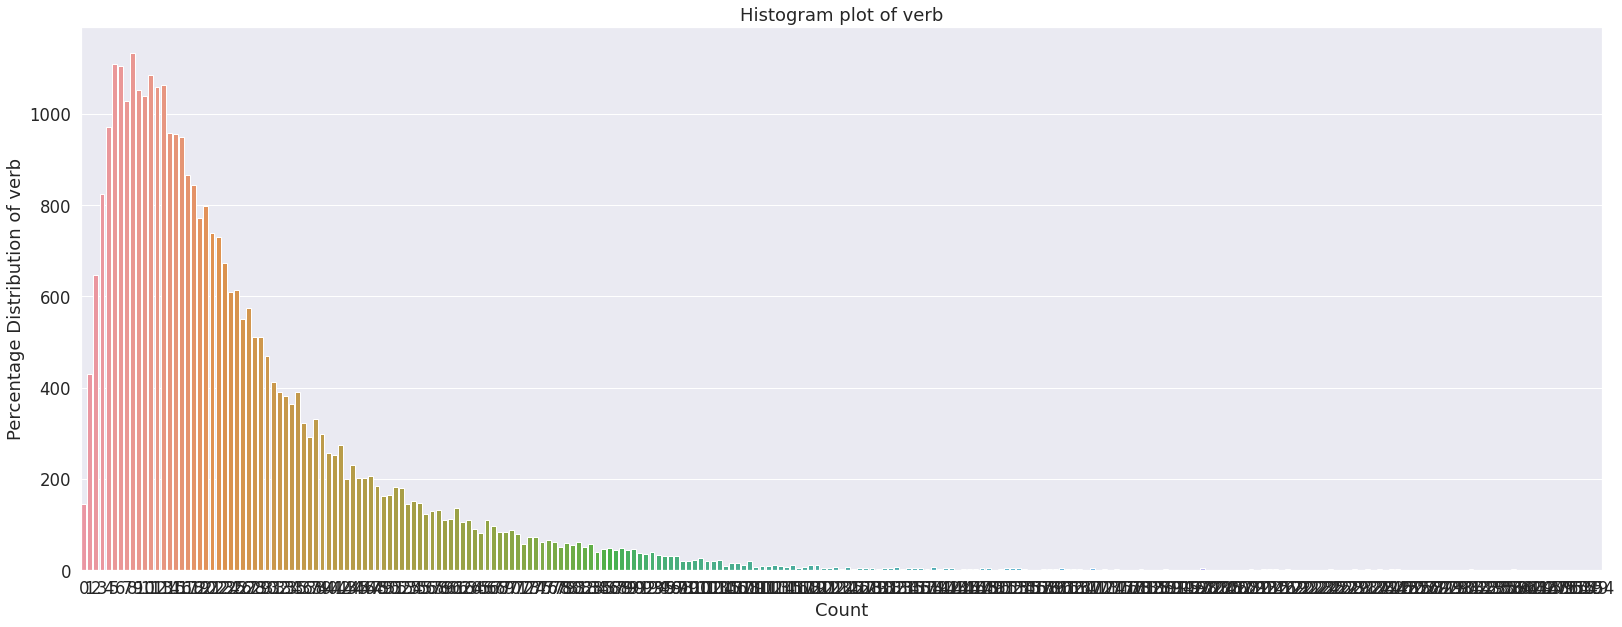

In [38]:
plt.figure(figsize=(12,8))

cnt = 0
for col in pos_df.columns :
  cnt += 1
  if cnt ==1 :
    plt.figure(figsize=(60,10))
  plt.subplot(1, 2, cnt)
  sns.countplot(x = pos_df[col])
  plt.title("Histogram plot of "+col)
  plt.xlabel('Count')
  plt.ylabel('Percentage Distribution of '+col)
  if cnt==2 :
    plt.show()
    cnt=0

From the word frequency in each product group category, an obvious difference is seen.

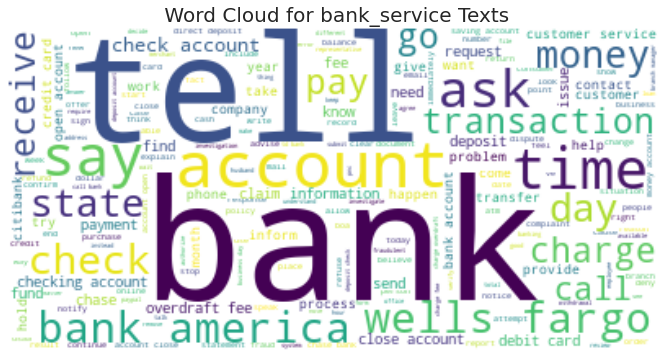

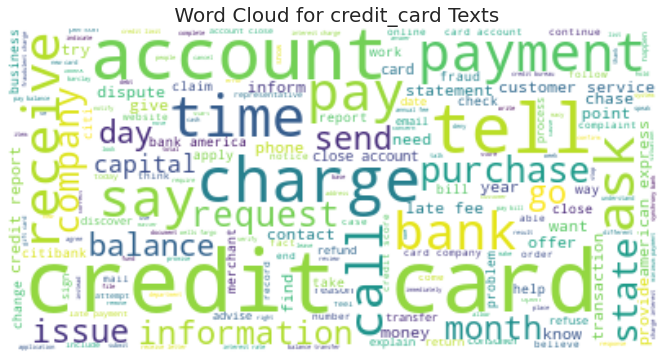

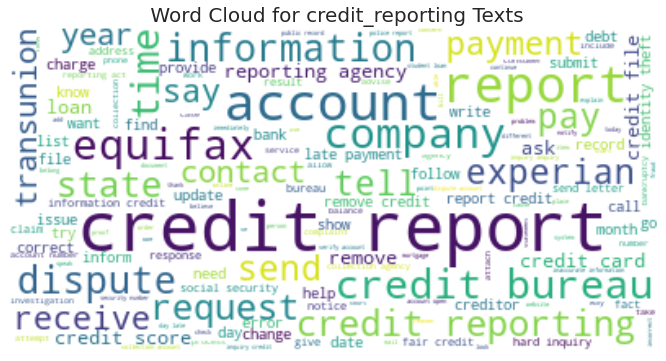

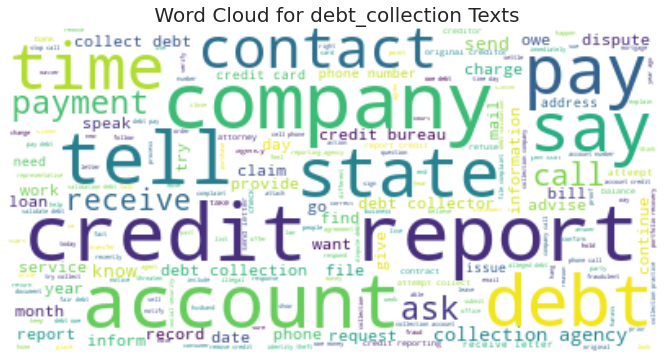

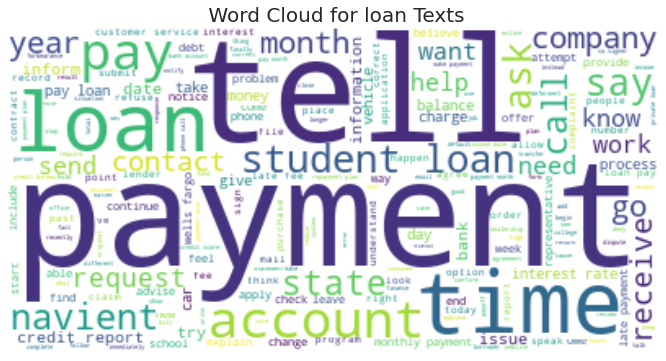

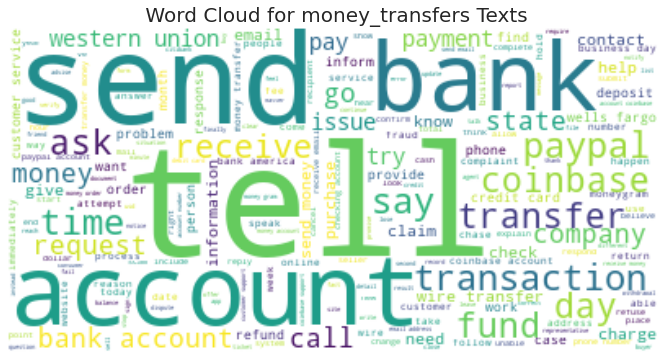

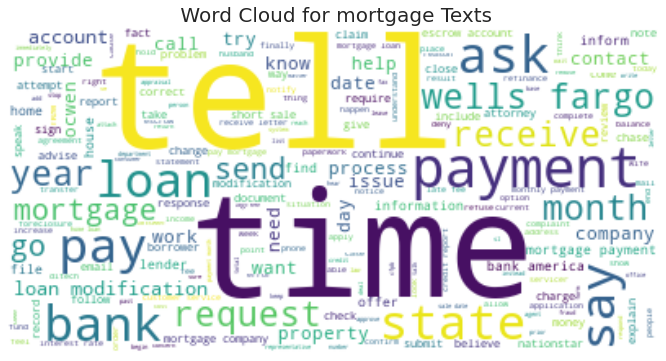

In [42]:
# Word Cloud: Negative
from wordcloud import WordCloud

for ele in casestudy_df_resamp.product_group.unique():
  cond = casestudy_df_resamp.product_group==ele
  # Generate a word cloud image
  wordcloud = WordCloud(background_color="white").generate(" ".join(casestudy_df_resamp[cond].text_processed_no_stopword))
  # Display the generated image:
  plt.figure(figsize=(30,6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(" Word Cloud for "+ele+" Texts", fontsize = 20)
  plt.show()

In [67]:
hashdict = {}
for ele in casestudy_df_resamp.product_group.unique():
  cond = casestudy_df_resamp.product_group==ele
  # Word Frequency for Clean Speeches
  plt.figure(figsize=(300,60))
  counts = Counter(" ".join(casestudy_df_resamp[cond].text_processed_no_stopword).split())
  labels, values = zip(*counts.items())

  # sort your values in descending order
  indSort = np.argsort(values)[::-1]

  # rearrange your data
  labels = np.array(labels)[indSort][1:30]
  values = np.array(values)[indSort][1:30]
  hashdict[ele] = np.array(labels)[indSort][1:11]

  indexes = np.arange(len(labels))
  bar_width = 0.1
  plt.bar(indexes, values, color='#4f6d5f')

  # add labels
  plt.xticks(indexes + bar_width, labels)
  plt.xticks(fontsize=90,rotation=10) 
  plt.yticks(fontsize=90) 
  plt.title("Word Frequency from "+ele,fontsize=100)
  plt.show()

IndexError: ignored

<Figure size 21600x4320 with 0 Axes>

## 2c. Feature Engineering: TF-IDF
Term Frequency - Inverse Document Frequency

I choose TFIDF approach over bag-of-word to emphasizes words that are less repetitive in the document and have more term frequency in a sentence versus a bow approach of using word count emphasizing higher word frequency. 

TF-IDF on the textual data is run with following features:

**max_df=0.25**: This drops words that occur in more than one fourth the documents.

**min_df=2**: This makes the vectorizer only use words that appear at least twice.

**use_idf**=True: This makes the vectorizer use inverse document frequencies in 
weighting.

**norm=u'l2'**: This applies a correction factor so that longer and shorter 
documents get treated equally.

**smooth_idf**=True: This adds 1 to all document frequencies, as if an extra document existed that used every word once. This prevents divide-by-zero errors.

I by defaults will use a **single-gram** placing more emphasize on the word occurence rather than the positioning

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.25, min_df=2, lowercase=False, use_idf=True, norm=u'l2', smooth_idf=True)
# applying the vectorizer
X = vectorizer.fit_transform(casestudy_df_resamp.text_processed_no_stopword)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [7]:
tfidf_df

,PRON,aa,aaa,aaaa,aaccount,aacount,aadvantage,aafe,aafes,aag,aand,aargon,aarp,ab,aba,aback,abandon,abandonment,abate,abatement,abbreviate,abbreviation,abc,abd,abet,abhorrent,abide,abiding,ability,able,abnormal,abnormally,abo,abode,abother,abou,about,aboutxx,aboutxxxx,abr,...,yellow,yelp,yen,yep,yer,yes,yester,yesterday,yhe,yhey,yield,yment,yo,york,youi,yound,young,yousent,yousubject,youth,youwill,youxxxx,ypur,yr,yrs,ys,ystem,ytd,yup,zenco,zero,zilch,zion,zions,zip,zipper,zombie,zone,zoom,zwicker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.032044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Classification Modeling

For predictive test, I use the TF-IDF score along with structural information. In process I test 3 different regression models (supervised learning)

1. Logistic Regression
2. Random Forest Classifier
3. Gradient Boosting Classifier

Based on the available computational capacity, I will only run prediction on the single gram TFIDF. 2 gram TFIDF predictive methods requires a high computational load.

## 3a. Splitting Data in Test and Train Datasets

I split the data as 20% test (unseen) and 80% train(seen) data from the TF-IDF table.

Since many unseen cases outside our resampled data has been left out, I will run our trained model on those data as well.

In [77]:
# Standarizing the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_str_std = scaler.fit_transform(casestudy_df_resamp[['number_of_words','number_of_paragraph','non_alpha_digit']])

In [6]:
from sklearn.model_selection import train_test_split

Y = casestudy_df_resamp.product_group
X = np.array(tfidf_df)
# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [10]:
from collections import Counter
Counter(y_test)

Counter({'bank_service': 956,
         'credit_card': 987,
         'credit_reporting': 962,
         'debt_collection': 996,
         'loan': 1023,
         'money_transfers': 964,
         'mortgage': 1059})

## 3b. Comparing Various Classification Models

I will be trying various ML modeling methods to arrive at best possible accuracy that can be achieved. The modelling should achieving the following criteria

1.  High accuracy scores in general
2.  High F1-score

I will also compare various schemes of classifiers:
1.  One versus Rest
2.  Multinomial

In [7]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(24, 16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### 0. Dummy Classifier

Since our dataset is balanced, a dummy classifier helps in establishing a benchmark. All the consequent performance metrics can be compared with the dummy classifier

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

    bank_service       0.14      1.00      0.24       956
     credit_card       0.00      0.00      0.00       987
credit_reporting       0.00      0.00      0.00       962
 debt_collection       0.00      0.00      0.00       996
            loan       0.00      0.00      0.00      1023
 money_transfers       0.00      0.00      0.00       964
        mortgage       0.00      0.00      0.00      1059

        accuracy                           0.14      6947
       macro avg       0.02      0.14      0.03      6947
    weighted avg       0.02      0.14      0.03      6947

Prediction score for Dummy Classifier 0.13761335828415144


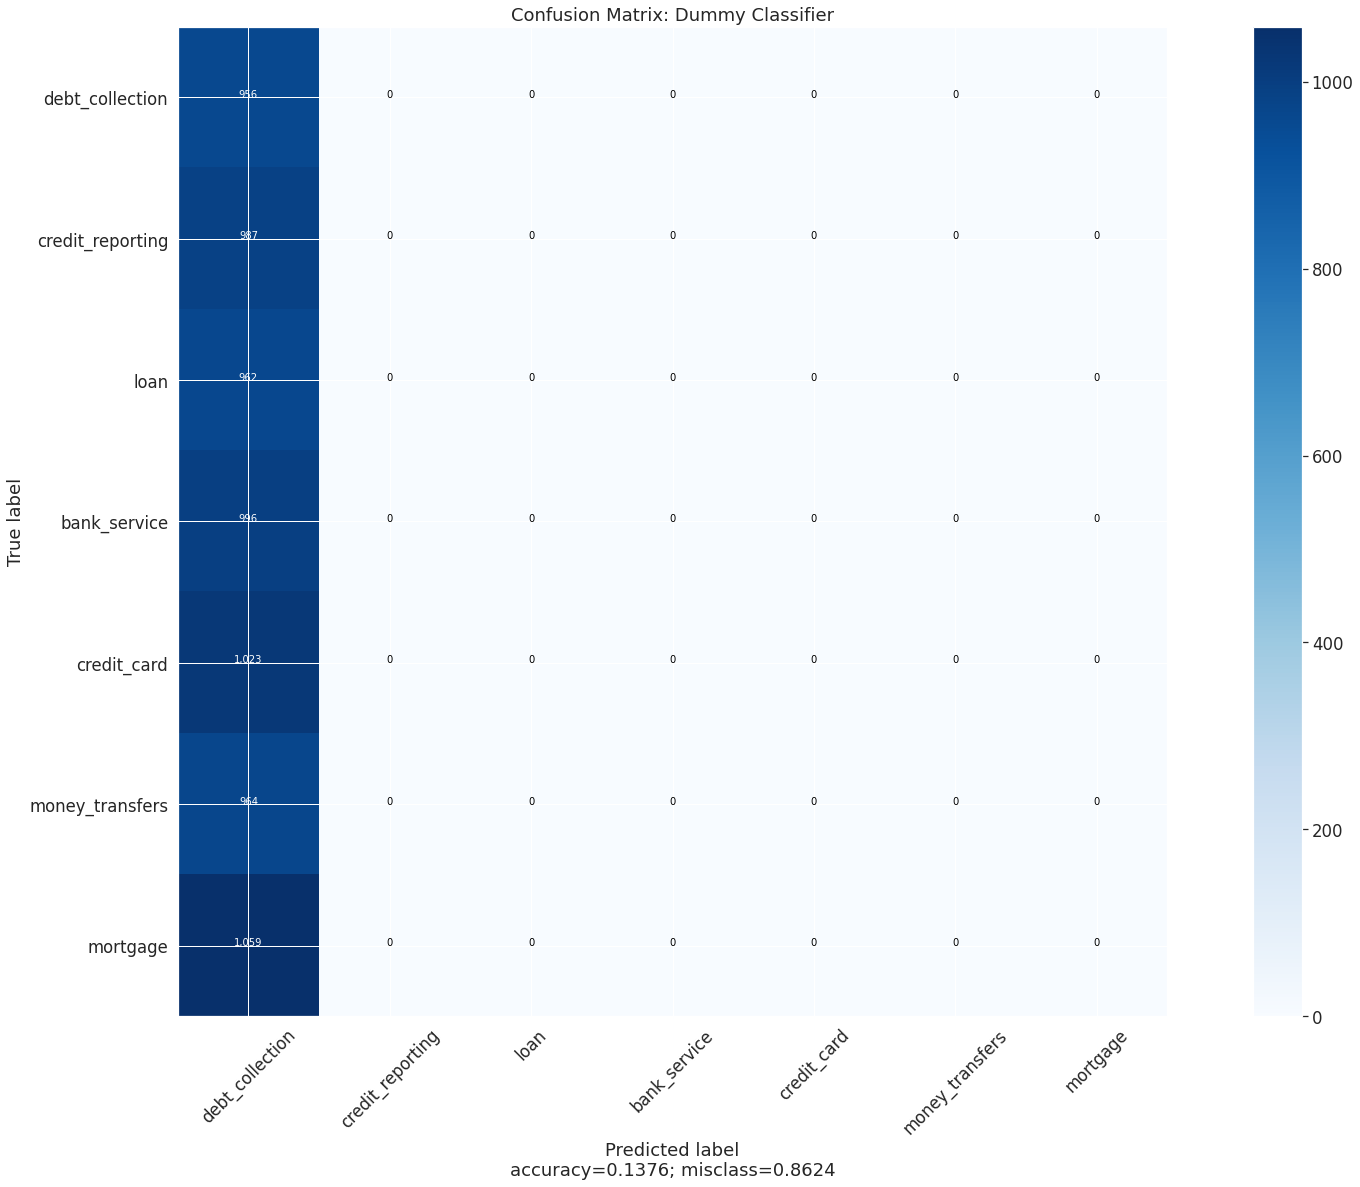

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)

# first generate predictions on the test data
dm_predictions = dummy.predict(X_test)
dm_report = classification_report(y_test, dm_predictions)
print(dm_report)

print("Prediction score for Dummy Classifier {}".format(dummy.score(X_test, y_test)))

# Confusion Matrix
confusion = confusion_matrix(y_test, dummy.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names=Counter(y_test).keys(), title = 'Confusion Matrix: Dummy Classifier',normalize=False)

###1. Logistic Regression : One over Rest (Without Hyper-Tuning)


OVR Logistic Regression using original TF-IDF table

Accuracy: 83%
F1 Score: 78% to 92%

The accuracy and f1-scores are in general good scores for classification problems.

                  precision    recall  f1-score   support

    bank_service       0.78      0.78      0.78       956
     credit_card       0.81      0.83      0.82       987
credit_reporting       0.81      0.77      0.79       962
 debt_collection       0.78      0.84      0.81       996
            loan       0.85      0.84      0.84      1023
 money_transfers       0.87      0.86      0.87       964
        mortgage       0.92      0.92      0.92      1059

        accuracy                           0.83      6947
       macro avg       0.83      0.83      0.83      6947
    weighted avg       0.84      0.83      0.83      6947

Prediction score for One-over-Rest Logistic Classifier 0.834892759464517


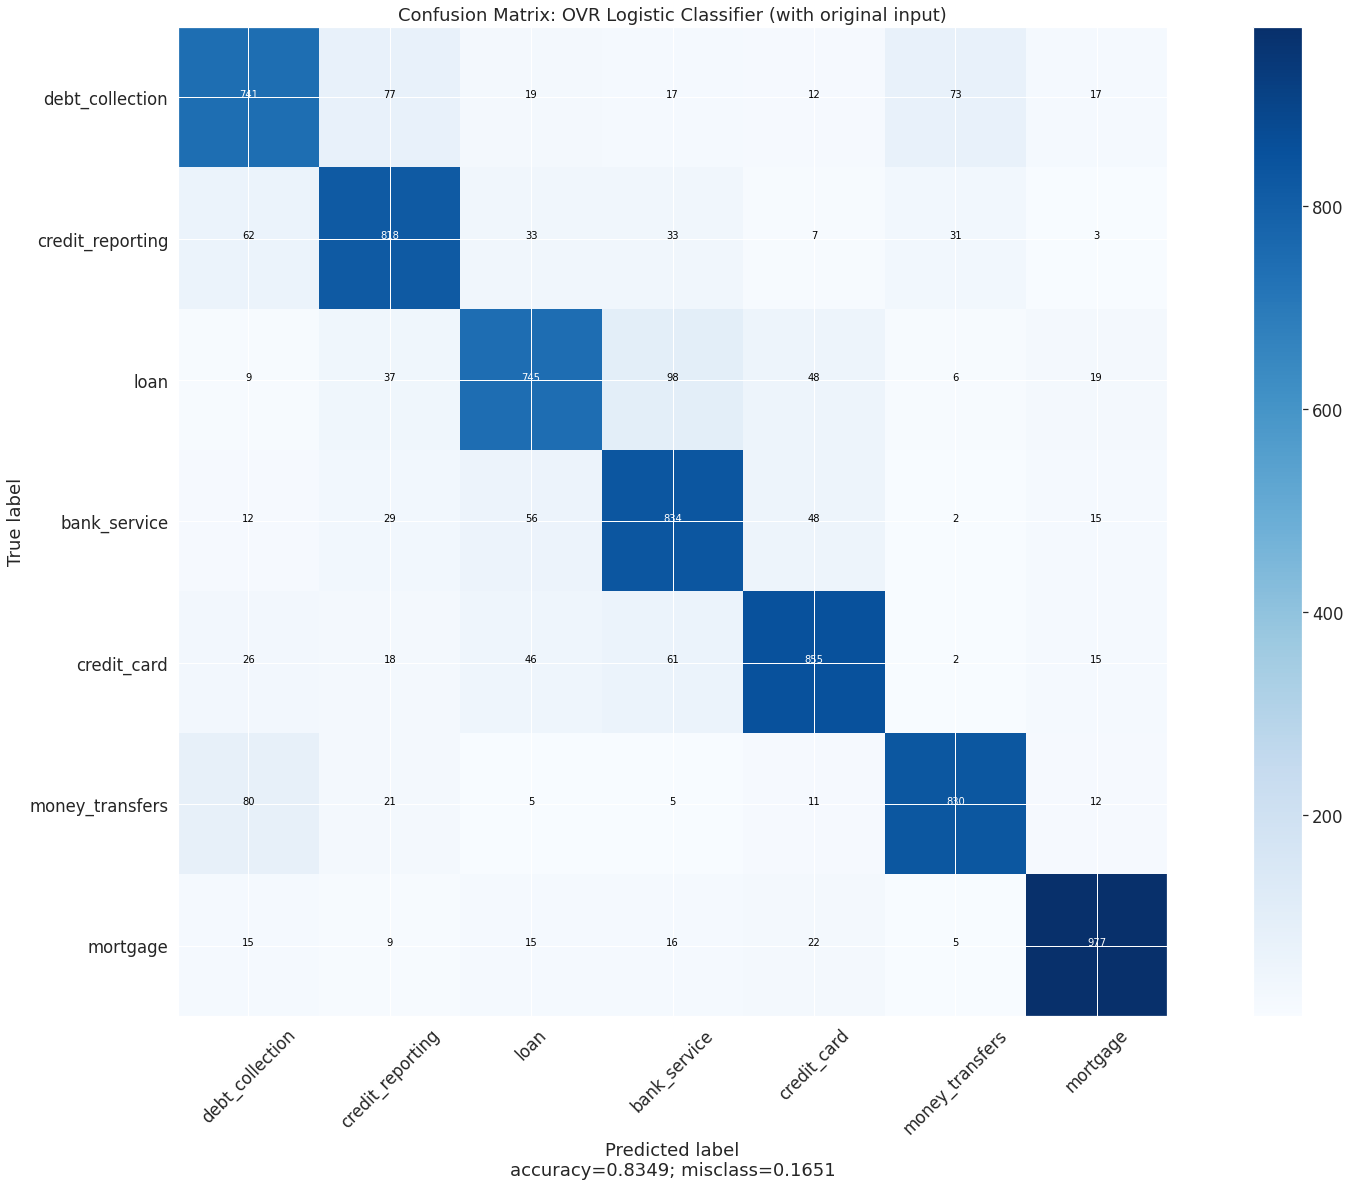

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Using ovr
ovr_lr_clf = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=53)
ovr_lr_clf.fit(X_train, y_train)

# first generate predictions on the test data
ovr_predictions = ovr_lr_clf.predict(X_test)
ovr_report = classification_report(y_test, ovr_predictions)
print(ovr_report)

print("Prediction score for One-over-Rest Logistic Classifier {}".format(ovr_lr_clf.score(X_test, y_test)))

confusion = confusion_matrix(y_test, ovr_lr_clf.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names=Counter(y_test).keys(), title = 'Confusion Matrix: OVR Logistic Classifier (with original input)',normalize=False)

###1b. Logistic Regression : Multinomial (Without Hyper-Tuning)

Result is almost similar to OVR option

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                  precision    recall  f1-score   support

    bank_service       0.79      0.78      0.78       956
     credit_card       0.81      0.83      0.82       987
credit_reporting       0.80      0.78      0.79       962
 debt_collection       0.79      0.83      0.81       996
            loan       0.84      0.83      0.84      1023
 money_transfers       0.88      0.85      0.86       964
        mortgage       0.93      0.91      0.92      1059

        accuracy                           0.83      6947
       macro avg       0.83      0.83      0.83      6947
    weighted avg       0.83      0.83      0.83      6947

Prediction score for Multinomial Logistic Classifier 0.8320138189146394


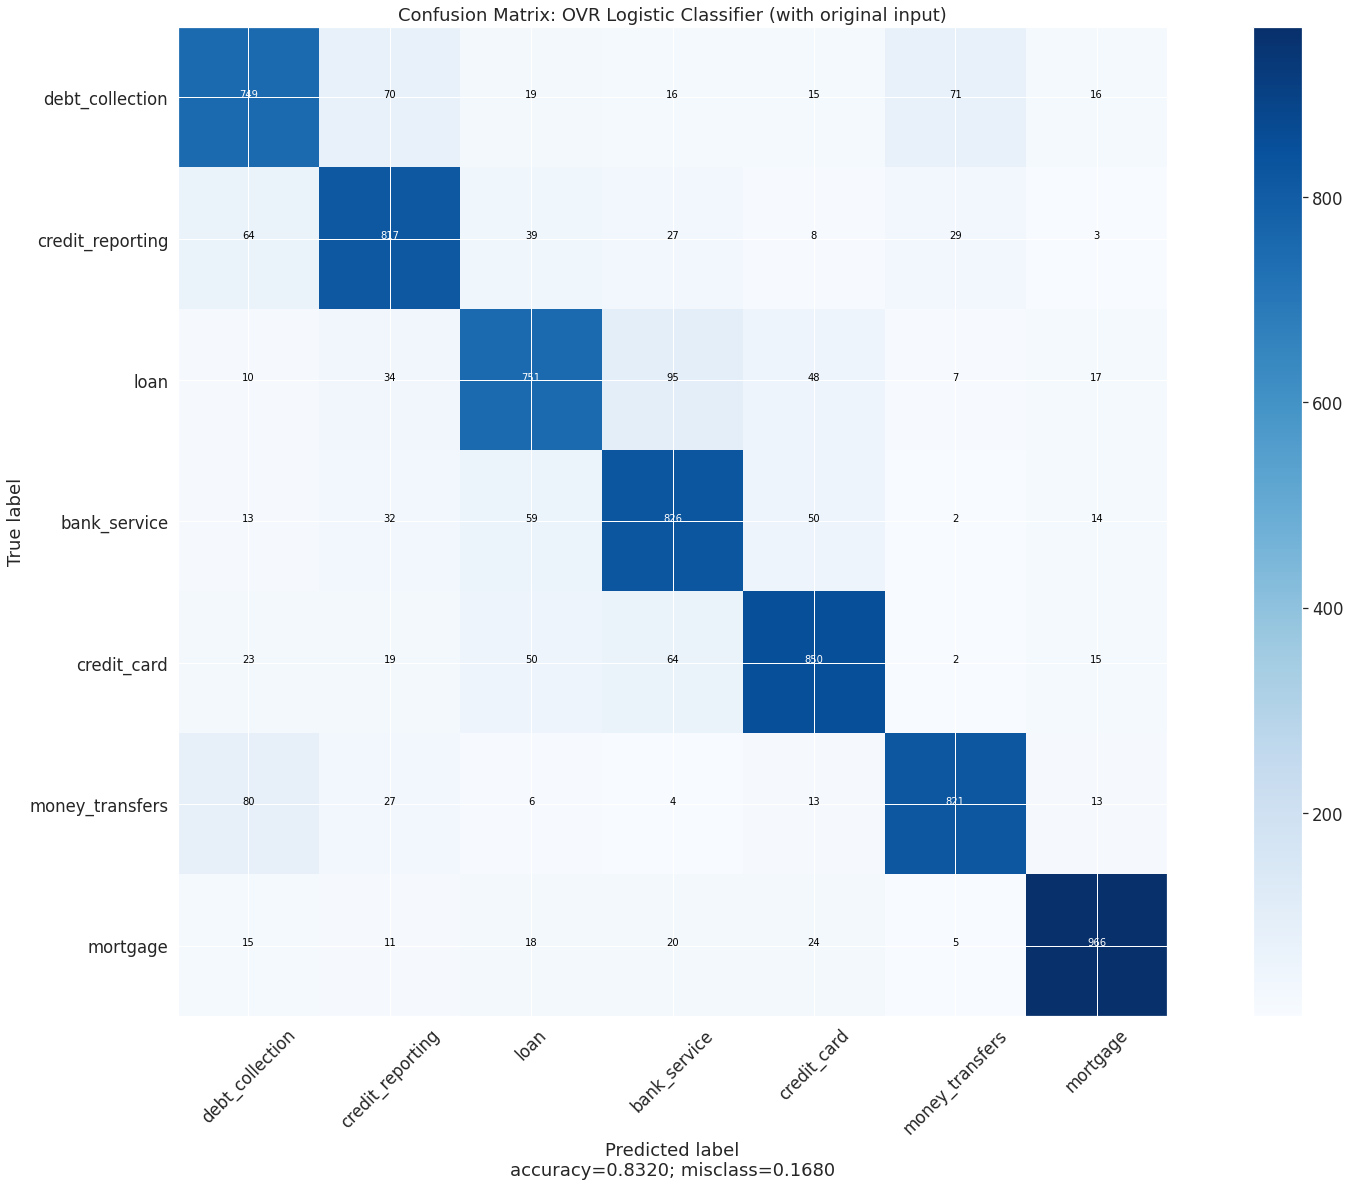

In [22]:
# Using ovr
ovr_lr_clf2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=53)
ovr_lr_clf2.fit(X_train, y_train)

# first generate predictions on the test data
ovr_predictions = ovr_lr_clf2.predict(X_test)
ovr_report = classification_report(y_test, ovr_predictions)
print(ovr_report)

print("Prediction score for Multinomial Logistic Classifier {}".format(ovr_lr_clf2.score(X_test, y_test)))

confusion = confusion_matrix(y_test, ovr_lr_clf2.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names=Counter(y_test).keys(), title = 'Confusion Matrix: OVR Logistic Classifier (with original input)',normalize=False)

###2. Random Forest Classifier (Without Hyper-Tuning)

Acuracy and f1-score levels are overall worse than Logistical Classifiers. May need some tuning of parameters for better model performance

                  precision    recall  f1-score   support

    bank_service       0.74      0.73      0.74       956
     credit_card       0.77      0.77      0.77       987
credit_reporting       0.78      0.77      0.77       962
 debt_collection       0.77      0.80      0.78       996
            loan       0.82      0.80      0.81      1023
 money_transfers       0.84      0.83      0.83       964
        mortgage       0.91      0.91      0.91      1059

        accuracy                           0.80      6947
       macro avg       0.80      0.80      0.80      6947
    weighted avg       0.80      0.80      0.80      6947

Prediction score for Random Forest Classifier 0.803080466388369


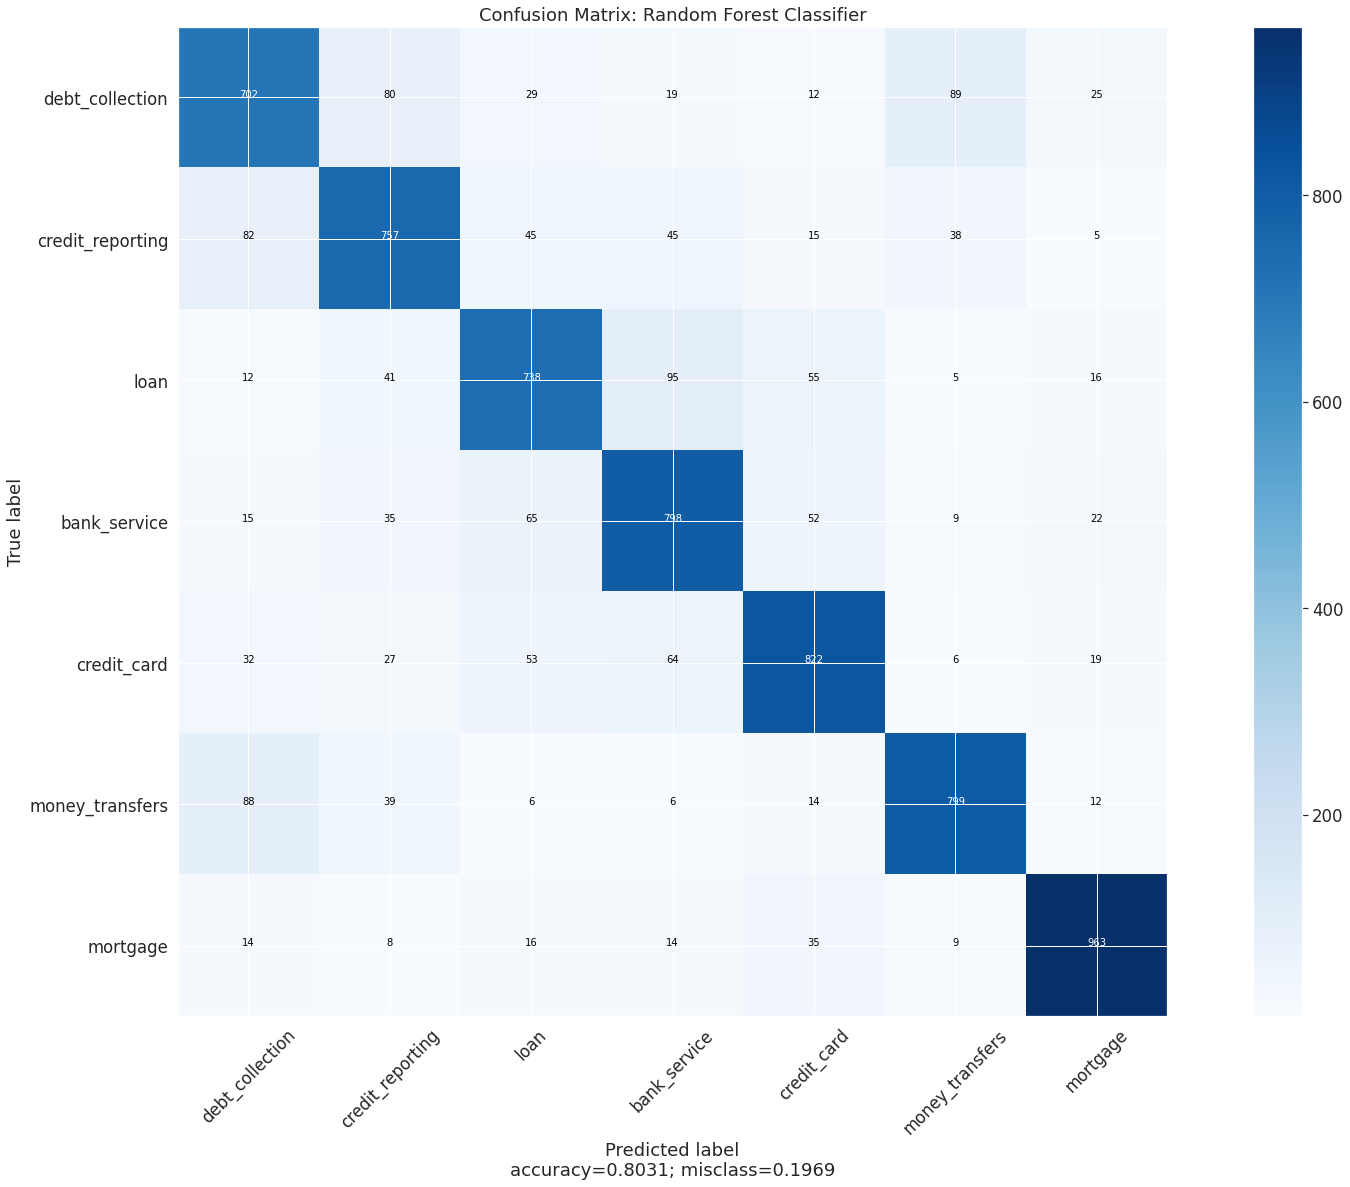

In [23]:
from sklearn.metrics import  classification_report, confusion_matrix


rf_clf = RandomForestClassifier(n_estimators = 50,criterion='gini', max_features = 'auto', random_state=64)
#rf_clf = RandomForestClassifier(n_estimators = 50,criterion='entropy', max_features = 'auto', random_state=64)
rf_clf.fit(X_train, y_train)

# first generate predictions on the test data
rf_predictions = rf_clf.predict(X_test)
rf_report = classification_report(y_test, rf_predictions)
print(rf_report)

print("Prediction score for Random Forest Classifier {}".format(rf_clf.score(X_test, y_test)))

# Confusion Matrix
confusion = confusion_matrix(y_test, rf_clf.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names=Counter(y_test).keys(), title = 'Confusion Matrix: Random Forest Classifier',normalize=False)

To generate TPR and FPR along with ROC curves
(not run)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
y_score = OneVsRestClassifier(RandomForestClassifier(n_estimators = 50,criterion='gini', max_features = 'auto', random_state=64)).fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### 3. Support Vector Classifier (Without Hyper-Tuning)

In [ ]:
from sklearn.svm import SVC 

svc_clf = SVC(kernel = 'linear')
svc_clf.fit(X_train, y_train)

# first generate predictions on the test data
svc_predictions = svc_clf.predict(X_test)
svc_report = classification_report(y_test, svc_predictions)
print(rf_report)

print("Prediction score for Support Vector Classifier {}".format(svc_clf.score(X_test, y_test)))

# Confusion Matrix
confusion = confusion_matrix(y_test, svc_clf.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names=Counter(y_test).keys(), title = 'Confusion Matrix: Random Forest Classifier',normalize=False)

### 4. Gradient Boosting Methods (Without Hyper Tuning)

In [ ]:
from sklearn.metrics import  classification_report, confusion_matrix

from sklearn import ensemble
params = {'n_estimators': 30,
          'max_depth': 3,
          'loss': 'deviance',
          'random_state': 0}

# Classification Modelling for amountpaidonbuildingclaim
gb_clf = ensemble.GradientBoostingClassifier(**params)
gb_clf.fit(X_train, y_train)

# first generate predictions on the test data
gb_predictions = gb_clf.predict(X_test)
gb_report = classification_report(y_test, gb_predictions)
print(gb_report)

print("Prediction score for Gradient Boosting Classifier {}".format(gb_clf.score(X_test, y_test)))

# Confusion Matrix
confusion = confusion_matrix(y_test, gb_clf.predict(X_test))
plot_confusion_matrix(cm=confusion, target_names=Counter(y_test).keys(), title = 'Confusion Matrix: Gradine Boosting Classifier',normalize=False)

### Saving logistical regression model and TF-IDF vectorizer 

In [12]:
import pickle
# save the model to disk
fileloc = '/content/gdrive/My Drive/Colab Notebooks/Wells Fargo Assignment/'
pickle.dump(ovr_lr_clf, open(fileloc+"10122020_logistical_regression_model.sav", 'wb'))
pickle.dump(vectorizer, open(fileloc+"10122020_tfidf_vectorizer.sav", "wb"))
 
# load the model from disk
loaded_model = pickle.load(open(fileloc+"10122020_logistical_regression_model.sav", 'rb'))
loaded_vectorizer = pickle.load(open(fileloc+"10122020_tfidf_vectorizer.sav", "rb"))

#result = loaded_model.score(X_test, y_test)
#print(result)

## 3c. Grid Search and Cross Validation

A grid search method is needed to tune the model parameter and achieve better results. Also a cross-validation fold (CV) testing helps in determing any overfitting related issues with modelling. 

Due to computation limitation, I will only run logistical and random forest classifier as test.

From the grid search validation, it is shown that Logistical Classifier performed better than Random Forest Classifier with more accuracy scores. Some level of overfitting can be seen as the performances between the training and test dataset are slightly different.

In [66]:
from sklearn.model_selection import GridSearchCV

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()

lr_params = {'fit_intercept':[True,False], 'penalty':['l1','l2']}

rfc_params = {"n_estimators": [25,50,100],
              "max_depth": [2, 5,10],
              "min_samples_split": [2, 5 , 9]}

clf_lr = GridSearchCV(lr, lr_params, cv=5)
clf_lr.fit(X_train, y_train)

clf_rfc = GridSearchCV(rfc, rfc_params, cv=5)
clf_rfc.fit(X_train, y_train)


print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', clf_lr.score(X_train, y_train))
print('\nTest set score:', clf_lr.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', clf_rfc.score(X_train, y_train))
print('\nTest set score:', clf_rfc.score(X_test, y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITER

----------------------Logistic Regression Scores----------------------
Training set score: 0.8729576045490535

Test set score: 0.8320138189146394
----------------------Random Forest Scores----------------------
Training set score: 0.8010508889368747

Test set score: 0.7778897365769397


In [71]:
print("Performance of Logistical Regression Multi-Class Classifier")
# print best parameter after tuning 
print(clf_lr.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(clf_lr.best_estimator_) 

print("\n")

print("Performance of Random Forest Multi-Class Classifier")
# print best parameter after tuning 
print(clf_rfc.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(clf_rfc.best_estimator_) 

Performance of Logistical Regression Multi-Class Classifier
{'fit_intercept': True, 'penalty': 'l2'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Performance of Random Forest Multi-Class Classifier
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None,

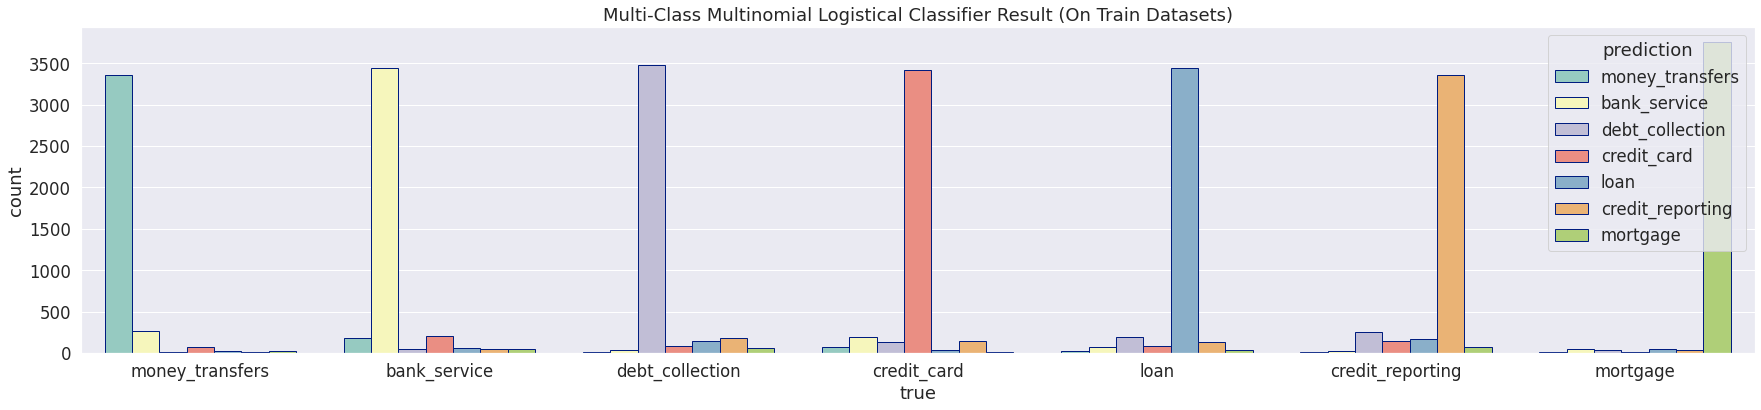

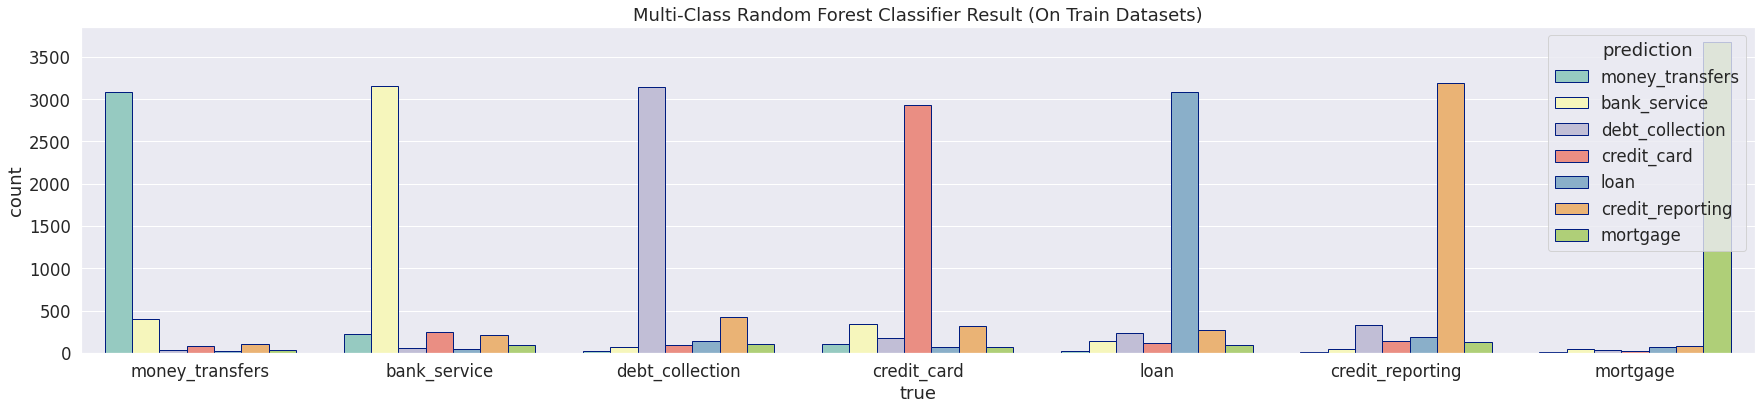

In [75]:
df = pd.DataFrame({'true': y_train,'prediction': clf_lr.predict(X_train)})
plt.figure(figsize=(30, 6))
sns.countplot(x="true", hue="prediction", data=df,palette="Set3",edgecolor=sns.color_palette("dark", 1))
plt.title("Multi-Class Multinomial Logistical Classifier Result (On Train Datasets)")
plt.show()

df = pd.DataFrame({'true': y_train,'prediction': clf_rfc.predict(X_train)})
plt.figure(figsize=(30, 6))
sns.countplot(x="true", hue="prediction", data=df,palette="Set3",edgecolor=sns.color_palette("dark", 1))
plt.title("Multi-Class Random Forest Classifier Result (On Train Datasets)")
plt.show()

## 3d. Validating on Unsampled (Unseen) Data

I also validate the model to the unseen record from the unsampled dataset. The purpose of this test is to observe any changes in the model performance due to
1. Possible unsampling majority product group population and 
2. Limit tf-idf vocabulary from training dataset

I randomly sample 50k complaint record in the unseen dataset. Note that all the cases of money_transfer has been removed. I'm observing the model performance for various classed to indicate any changes. 

For example sake, I select the Logistical Regression Model

In [15]:
casestudy_df_nonlearn = casestudy_df[~casestudy_df.complaint_id.isin(casestudy_df_resamp.complaint_id)].sample(n=50000)
casestudy_df_nonlearn = casestudy_df_nonlearn.reset_index()
casestudy_df_nonlearn.drop(['index'],axis=1,inplace=True)
casestudy_df_nonlearn

,complaint_id,product_group,text
0,2929889,debt_collection,I have been a victim of identity theft.
1,2755873,credit_reporting,RE : Remaing inaccurate items. I am sending th...
2,2255400,debt_collection,"To whom it may concern, I was planning on buyi..."
3,2011609,bank_service,SYNCB/JCP ACCOUNT NUMBERs : XXXX XXXX/XXXX/XXX...
4,2663747,debt_collection,I had service with XXXX XXXX during a pre-pric...
...,...,...,...
49995,2893163,credit_reporting,These inquiries is on my credit report and I n...
49996,2897346,debt_collection,This complaint is with original company XXXX X...
49997,1298116,mortgage,I was {$48.00} behind on our mortgage because ...
49998,1891499,mortgage,I am in process of refinancing a Chase loan. W...


In [16]:
def text_cleaner(text):
    # visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  better get rid of it now!
    text = ' '.join(text.split())
    text = re.sub(r'\bX\S+', "", text)
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+|\d*\w)\b", " ", text)
    text = re.sub("[']",'',text)
    text = re.sub("[\W]",' ',text)
    text = ' '.join(text.split())
    return text.lower()

for ind,ele in enumerate(casestudy_df_nonlearn.text):
  # Remove white spacing before converting to sentences 
  casestudy_df_nonlearn.loc[ind,'text_processed'] = text_cleaner(ele)
  if ind%10000 == 0:
    print(ind)

0
10000
20000
30000
40000


In [17]:
casestudy_df_nonlearn

,complaint_id,product_group,text,text_processed
0,2929889,debt_collection,I have been a victim of identity theft.,have been victim of identity theft
1,2755873,credit_reporting,RE : Remaing inaccurate items. I am sending th...,re remaing inaccurate items am sending this le...
2,2255400,debt_collection,"To whom it may concern, I was planning on buyi...",to whom it may concern was planning on buying ...
3,2011609,bank_service,SYNCB/JCP ACCOUNT NUMBERs : XXXX XXXX/XXXX/XXX...,syncb jcp account numbers fl phone attention t...
4,2663747,debt_collection,I had service with XXXX XXXX during a pre-pric...,had service with during pre priced trial perio...
...,...,...,...,...
49995,2893163,credit_reporting,These inquiries is on my credit report and I n...,these inquiries is on my credit report and nee...
49996,2897346,debt_collection,This complaint is with original company XXXX X...,this complaint is with original company but ha...
49997,1298116,mortgage,I was {$48.00} behind on our mortgage because ...,was behind on our mortgage because our town ra...
49998,1891499,mortgage,I am in process of refinancing a Chase loan. W...,am in process of refinancing chase loan we hav...


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer(max_df=0.25, min_df=2, lowercase=False, use_idf=True, norm=u'l2', smooth_idf=True)
# applying the vectorizer
X_nonlearn = loaded_vectorizer.transform(casestudy_df_nonlearn.text_processed)
tfidf_nonlearn_df = pd.DataFrame(X_nonlearn.toarray(), columns=loaded_vectorizer.get_feature_names())

In [19]:
tfidf_nonlearn_df

,PRON,aa,aaa,aaaa,aaccount,aacount,aadvantage,aafe,aafes,aag,aand,aargon,aarp,ab,aba,aback,abandon,abandonment,abate,abatement,abbreviate,abbreviation,abc,abd,abet,abhorrent,abide,abiding,ability,able,abnormal,abnormally,abo,abode,abother,abou,about,aboutxx,aboutxxxx,abr,...,yellow,yelp,yen,yep,yer,yes,yester,yesterday,yhe,yhey,yield,yment,yo,york,youi,yound,young,yousent,yousubject,youth,youwill,youxxxx,ypur,yr,yrs,ys,ystem,ytd,yup,zenco,zero,zilch,zion,zions,zip,zipper,zombie,zone,zoom,zwicker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094843,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217126,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

    bank_service       0.80      0.61      0.69      3338
     credit_card       0.78      0.72      0.75      5247
credit_reporting       0.87      0.77      0.82     16379
 debt_collection       0.66      0.88      0.76     12161
            loan       0.74      0.74      0.74      5525
 money_transfers       0.00      0.00      0.00         0
        mortgage       0.93      0.79      0.85      7350

        accuracy                           0.78     50000
       macro avg       0.69      0.64      0.66     50000
    weighted avg       0.80      0.78      0.78     50000

Prediction score for One-over-Rest Logistic Classifier 0.7775


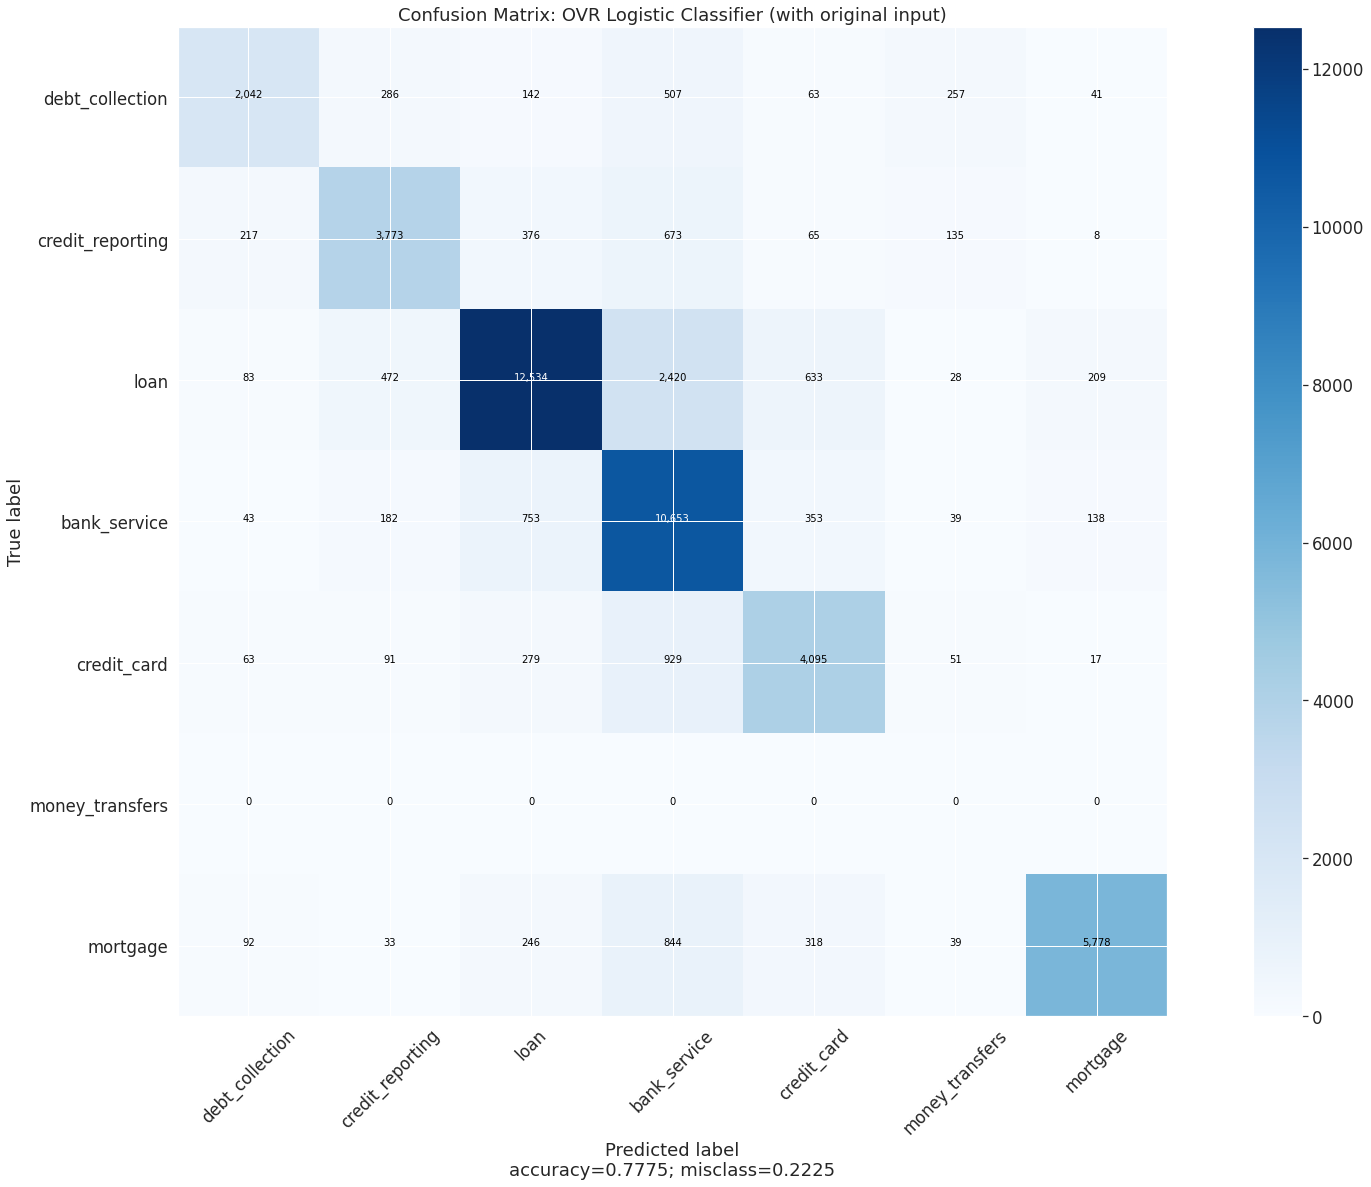

In [20]:
y_nonlearn = casestudy_df_nonlearn.product_group
X_nonlearn = np.array(tfidf_nonlearn_df)

# first generate predictions on the test data
ovr_predictions = loaded_model.predict(X_nonlearn)
ovr_report = classification_report(y_nonlearn, ovr_predictions)
print(ovr_report)

print("Prediction score for One-over-Rest Logistic Classifier {}".format(loaded_model.score(X_nonlearn, y_nonlearn)))

confusion = confusion_matrix(y_nonlearn, loaded_model.predict(X_nonlearn))
plot_confusion_matrix(cm=confusion, target_names=Counter(y_test).keys(), title = 'Confusion Matrix: OVR Logistic Classifier (with original input)',normalize=False)

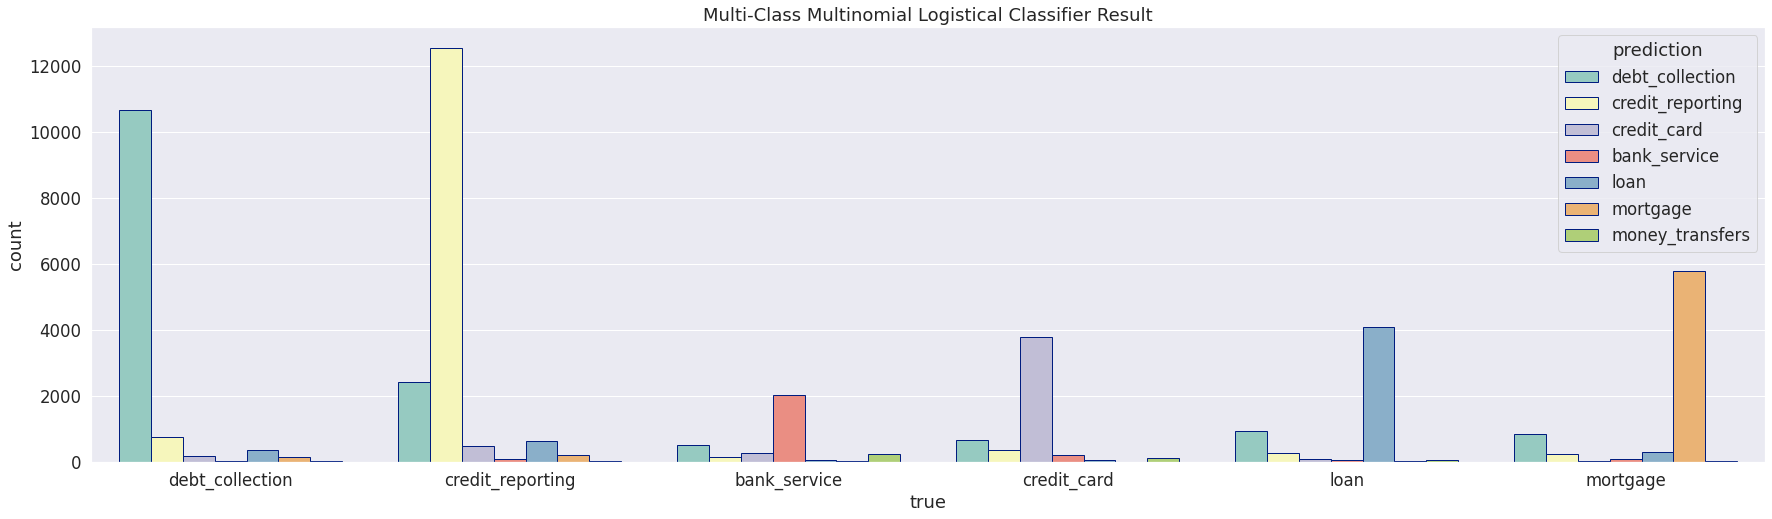

In [21]:
df = pd.DataFrame({'true': y_nonlearn,'prediction': loaded_model.predict(X_nonlearn)})
plt.figure(figsize=(30, 8))
sns.countplot(x="true", hue="prediction", data=df,palette="Set3",edgecolor=sns.color_palette("dark", 1))
plt.title("Multi-Class Multinomial Logistical Classifier Result")
plt.show()

#4 Conclusion

Using the collection of complaint corpus, a multi-class classification model was build which achieves upto 70% to 80% accuracy levels. The TF-IDF approach was used to process the textual information for modeling inputs. A resample of record was done to create generatized model and avoid overfitting problems.

The case of concerns or methodologies limitation are:

1. Issues related to limited vocabulary is always present. New complaint with different word collection will most like be recorded in future. Hence the build model need to be updated on regular basis to accomodate for increasing vocabulary.
3. Current collection of data was imbalanced in the beginning with less money_transfer complaints, this led to a reduction in sample size 
2. Feature embedding and feature selection criteria can still be used. Some features like structural information showed clear correlation with product_group cases. Also n-gram may be used to add contextual information
3. Gridsearch optimization of model parameters and tuning can be performed to achieve better performance metrics. Including more statistical models like k-mean, clustering algorithms, regularization would help
4. Cost function can be designed to penalize false negative errors
5. PCA or LDA based methosd may be used to remove low variance in data and reduce dimensions.
6. The data may also suffer from inconsistent labeled sentiments. However, More data statistically will help in reducing the modeling errors generated as a result of honoring the overall data trends and relationships
7. Limiting in wording count can be implement to avoid including highly worded complaint cases (may be considered as outlier data point)
